In [1]:
import re
import math
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from time import time
import IPython.display as Disp
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from underthesea import word_tokenize
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


# 1. Cleaning & Preprocessing

In [3]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
    #xoá khoảng trắng ở đầu và cuối mỗi câu
    text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [4]:
df['index_org'] = df.index

df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [5]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 17)

In [6]:
df['Human Feedback'].value_counts()

MATCH        996
NOT MATCH    966
Name: Human Feedback, dtype: int64

In [7]:
human_fb = pd.DataFrame(df.groupby('Human Feedback')['Feedback ID'].count()).reset_index()
human_fb

Human Feedback  Feedback ID
0          MATCH          996
1      NOT MATCH          966

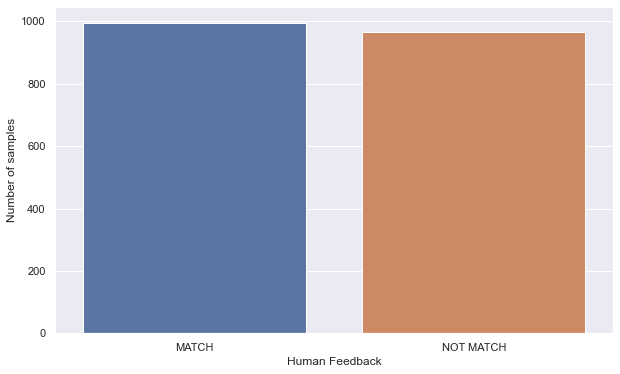

In [8]:
sb.set_theme()
plt.figure(figsize=(10, 6))
sb.barplot(data = human_fb, x = 'Human Feedback', y = 'Feedback ID')
plt.ylabel('Number of samples');

In [9]:
mask1 = df['Human Feedback'] == 'NOT MATCH'
mask2 = df['Human Feedback'] == 'MATCH'

df_neg = df[mask1].reset_index(drop = True)
df_pos = df[mask2].reset_index(drop = True)

print(df_neg.shape)
print(df_pos.shape)

(966, 17)
(996, 17)


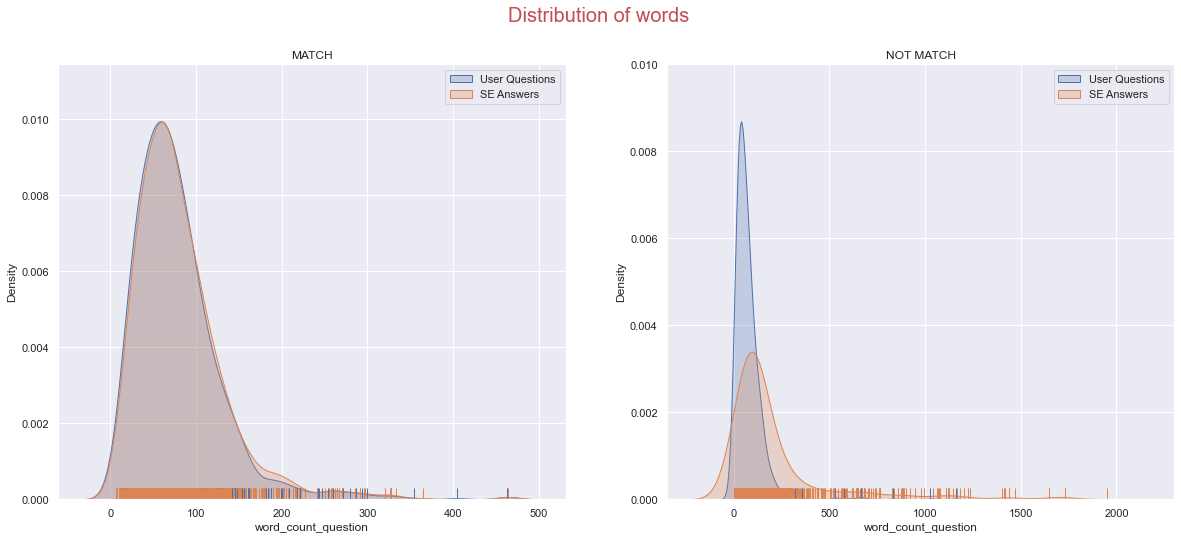

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sb.distplot(df_pos['word_count_lookup'], hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='User Questions')
sb.distplot(df_pos['word_count_question'],hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='SE Answers')
plt.title('MATCH')
plt.legend()
plt.subplot(122)
sb.distplot(df_neg['word_count_lookup'], hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='User Questions')
sb.distplot(df_neg['word_count_question'],hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='SE Answers')
plt.ylim([0, 0.01])
plt.title('NOT MATCH')
plt.legend()
plt.suptitle('Distribution of words', fontsize = 20, color = 'r');

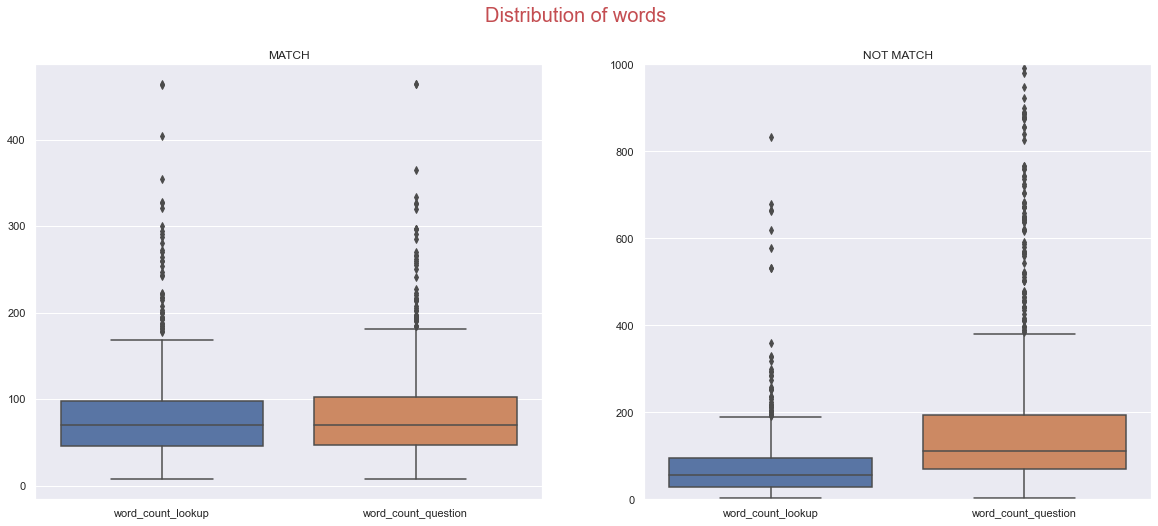

In [11]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.boxplot(data = df_pos[['word_count_lookup', 'word_count_question']])
plt.title('MATCH')
plt.subplot(122)
sb.boxplot(data = df_neg[['word_count_lookup', 'word_count_question']])
plt.ylim([0, 1000])
plt.title('NOT MATCH')
plt.suptitle('Distribution of words', fontsize = 20, color = 'r');

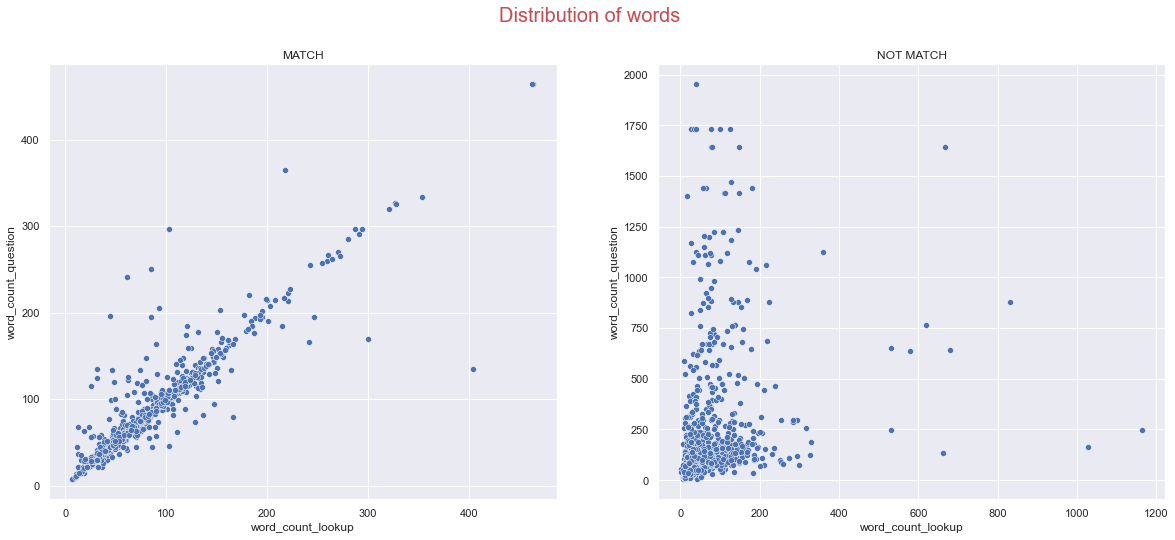

In [59]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.scatterplot(data = df_pos, x = df_pos['word_count_lookup'], y = df_pos['word_count_question'])
plt.title('MATCH')
plt.subplot(122)
sb.scatterplot(data = df_neg, x = df_neg['word_count_lookup'], y = df_neg['word_count_question'])
# plt.ylim([0, 1000])
plt.title('NOT MATCH')
plt.suptitle('Distribution of words', fontsize = 20, color = 'r');

In [13]:
df_neg['diff_word'] = abs(df_neg['word_count_question'] - df_neg['word_count_lookup'])
df_pos['diff_word'] = abs(df_pos['word_count_question'] - df_pos['word_count_lookup'])

my_bins = [-np.inf, 5, 10, 15, 20, np.inf]
my_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

df_neg['diff_bin'] = pd.cut(df_neg['diff_word'], bins=my_bins, labels=my_labels)
df_pos['diff_bin'] = pd.cut(df_pos['diff_word'], bins=my_bins, labels=my_labels)

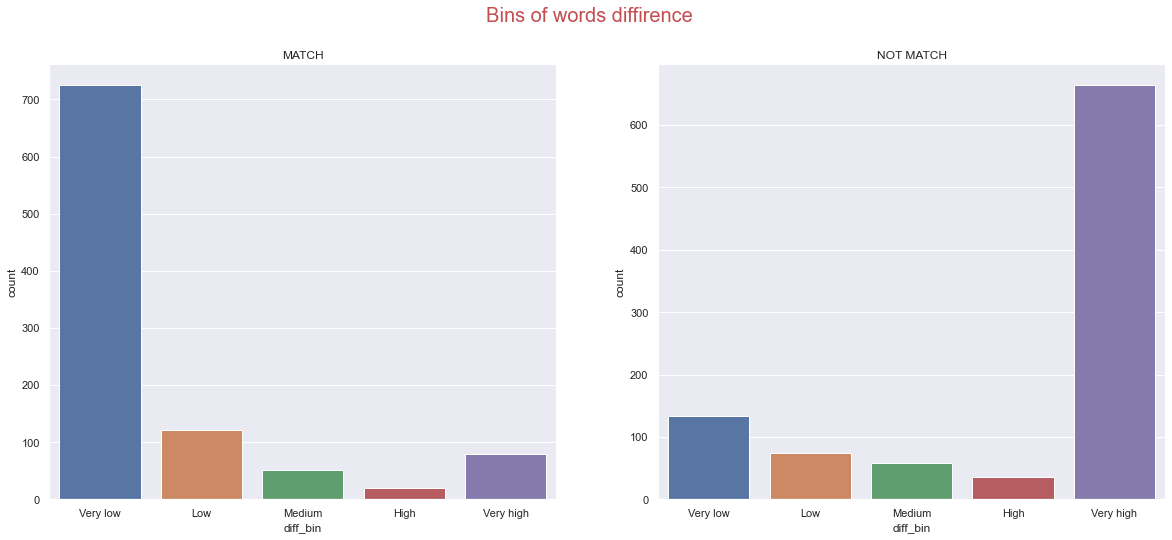

In [14]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_pos['diff_bin'])
plt.title('MATCH')
plt.subplot(122)
sb.countplot(df_neg['diff_bin'])
plt.title('NOT MATCH')
plt.suptitle('Bins of words diffirence', fontsize = 20, color = 'r');

In [15]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

In [16]:
tf_neg = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, min_df = 0)
tfidf_matrix_neg = tf_neg.fit_transform(df_neg['clean_question'])
tfidf_matrix_neg = pd.DataFrame(tfidf_matrix_neg.toarray(),
                                columns = tf_neg.get_feature_names())
tfidf_matrix_neg.head()
tfidf_matrix_neg.shape

(966, 5078)

In [17]:
tf_pos = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, min_df = 0)
tfidf_matrix_pos = tf_pos.fit_transform(df_pos['clean_question'])
tfidf_matrix_pos = pd.DataFrame(tfidf_matrix_pos.toarray(),
                                columns = tf_pos.get_feature_names())
tfidf_matrix_pos.head()
tfidf_matrix_pos.shape

(996, 2951)

In [18]:
# query1 = df_neg.iloc[0]['Lookup Text']
# query1_tf = tf.transform([clean_function(query1)])

In [19]:
sums_weight_neg = tfidf_matrix_neg.sum().sort_values(ascending = False)
sums_weight_neg.head(20)

frac      128.636168
sqrt       80.876945
y_         43.744151
3_         42.789605
_left      42.759790
a_         42.204091
_right     42.137976
sin        31.792342
câu        29.733071
cos        27.614087
10         26.399031
hàm_số     22.841276
cdot       21.957029
array      21.782922
cm         20.559843
_a         20.079465
2_         19.702702
_b         19.139230
12         18.093963
left       17.455349
dtype: float64

In [20]:
sums_weight_pos = tfidf_matrix_pos.sum().sort_values(ascending = False)
sums_weight_pos.head(20)

frac       96.222754
sqrt       63.826554
_right     41.319644
_left      40.322845
a_         37.663482
3_         31.045809
y_         30.898131
10         23.323375
câu        23.106899
cdot       21.038161
sin        20.700762
_a         20.526078
_b         19.597949
cos        17.456896
hàm_số     17.415767
tập_hợp    17.253365
circ       17.156025
_c         16.948978
pi         16.911072
2_         16.717087
dtype: float64

# 2. Cosine search in NOT MATCH Dataset

In [21]:
def cosine_search_all(queries, tf, tfidf_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    results = pd.DataFrame(columns = ['lookup_text', 'question_text', 'sim_score', 
                                      'cosine_word_count_question', 'cosine_diff_bin', 'cosine_image'])
    for q in queries:
        query = clean_function(q)
        query_tf = tf.transform([query])
        query_tf = pd.DataFrame(query_tf.toarray(),
                                columns = tf.get_feature_names())
        cosine_sim = cosine_similarity(query_tf, tfidf_matrix).flatten()
        related_index = cosine_sim.argsort()[-top_result:][::-1]
        cosine_sim = sorted(cosine_sim, reverse = True)
        similarities_score = cosine_sim[:top_result]
        result = pd.DataFrame({'lookup_text': q,
                               'question_text': data.iloc[related_index, :]['Question Text'].values,
                               'sim_score': similarities_score,
                               'cosine_word_count_question': data.iloc[related_index, :]['word_count_question'].values,
                               'cosine_diff_bin': data.iloc[related_index, :]['diff_bin'].values,
                               'cosine_image': data.iloc[related_index, :]['Question Image'].values}).head(1)
        results = pd.concat([results, result], ignore_index = True)
    if check_time:
        print('Time:', time() - t0)
    return results

In [22]:
result_neg = cosine_search_all(df_neg['Lookup Text'], tf_neg, tfidf_matrix_neg, df_neg)

Time: 38.26409196853638


In [23]:
result_neg

lookup_text  \
0    b) \( \left(\frac{-4}{15}-\frac{18}{19}\right)...   
1    Câu 49: Cho hàm số \( y=f(x) \) có đạo hàm là ...   
2    b. Giải phương trình: \( 2 \sin ^{2} x+\sqrt{3...   
3    8. Một khu đãt hình chữ nhật có chu vi là \( 3...   
4                                        \( 36-x=44 \)   
..                                                 ...   
961  \( x:\left(\frac{1}{2}+\frac{1}{3}\right)=\fra...   
962       h) \( -\frac{3}{8} x-0,75=-1 \frac{1}{2} \).   
963  Bài 23: Cho hàm số \( y=(m-1) x+m \)\n(d)\na. ...   
964  ç Bài 2. Viết các tập hợp sau bằng phương pháp...   
965  25. Phân tích đa thức sau thành nhân tư\na) \(...   

                                         question_text sim_score  \
0    a) \( \frac{2}{3}+\frac{-1}{3}+\frac{7}{15} \)...  0.856981   
1    Câu 49. Cho hàm số \( y=f(x) \) có đạo hàm \( ...  0.703904   
2    Bài 1:(4.0 điểm) Giải các phương trình lượng g...  0.820855   
3    Bài 3. \( (1,5 \) điểm) Giải bài toán sau bằng...  0.587243   
4                                 1) \( 36-x=44+3 x \)  0.603486   
..                                                 ...       ...   
961  a) \( x-\frac{1}{2}=3 \)\nb) \( \frac{x}{2}-\l...  0.982014   
962  11 \( 2 x-\frac{2}{3}-7 x=\frac{3}{2} x 1 \)\n...  0.548686   
963  Bài 8: Cho hàm số y \( =(m+4) x-m+6 \) (d)\na)...  0.523701   
964  13.VN Viết các tập hợp sau bằng phương pháp li...  0.909677   
965  : Phân tích các đa thức sau thành nhân từ\na) ...  0.648788   

    cosine_word_count_question cosine_diff_bin  \
0                          217       Very high   
1                          115        Very low   
2                          153       Very high   
3                           77       Very high   
4                           14             Low   
..                         ...             ...   
961                        193       Very high   
962                        201       Very high   
963                         84             Low   
964                        101       Very high   
965                        316       Very high   

                                          cosine_image  
0    https://s3.icankid.io/uploads/question/41bf56d...  
1    https://s3.icankid.io/uploads/question/aaa4976...  
2    https://s3.icankid.io/uploads/question/dc717ab...  
3    https://s3.icankid.io/uploads/question/3e9789b...  
4    https://s3.icankid.io/uploads/question/8f0f9fc...  
..                                                 ...  
961  https://s3.icankid.io/uploads/question/87d61d7...  
962  https://s3.icankid.io/uploads/question/7f65a36...  
963  https://s3.icankid.io/uploads/question/6f5bdbb...  
964  https://s3.icankid.io/uploads/question/e64f9e9...  
965  https://s3.icankid.io/uploads/question/e5aac09...  

[966 rows x 6 columns]

In [24]:
df_neg['search_result'] = result_neg['question_text']
df_neg['score'] = result_neg['sim_score']
df_neg['cosine_word_count_question'] = result_neg['cosine_word_count_question']
df_neg['cosine_diff_bin'] = result_neg['cosine_diff_bin']
df_neg['cosine_image'] = result_neg['cosine_image']

In [25]:
df_neg.head()

Feedback ID                                        Lookup Text  \
0       4416.0  b) \( \left(\frac{-4}{15}-\frac{18}{19}\right)...   
1       4423.0  Câu 49: Cho hàm số \( y=f(x) \) có đạo hàm là ...   
2       4425.0  b. Giải phương trình: \( 2 \sin ^{2} x+\sqrt{3...   
3       4426.0  8. Một khu đãt hình chữ nhật có chu vi là \( 3...   
4       4427.0                                      \( 36-x=44 \)   

                                       Question Text Feedback Type  \
0  a) \( \frac{2}{3}+\frac{-1}{3}+\frac{7}{15} \)...      NEGATIVE   
1  Câu 49. Cho hàm số \( y=f(x) \) có đạo hàm \( ...      NEGATIVE   
2  1) \( \sin ^{2} 2 x-(2+\sqrt{3}) \sin 2 x+\sqr...      NEGATIVE   
3  Bài 3. \( (1,5 \) điểm) Giải bài toán sau bằng...      NEGATIVE   
4                               1) \( 36-x=44+3 x \)      POSITIVE   

  Feedback Result Human Feedback  \
0           MATCH      NOT MATCH   
1       NOT_MATCH      NOT MATCH   
2       NOT_MATCH      NOT MATCH   
3       NOT_MATCH      NOT MATCH   
4       NOT_MATCH      NOT MATCH   

                                        Lookup Image  \
0  https://s3.icankid.io/uploads/question/9a7aa76...   
1  https://s3.icankid.io/uploads/question/a981260...   
2  https://s3.icankid.io/uploads/question/caa519f...   
3  https://s3.icankid.io/uploads/question/ade99a2...   
4  https://s3.icankid.io/uploads/question/8e5661e...   

                                      Question Image  index_org  \
0  https://s3.icankid.io/uploads/question/41bf56d...          0   
1  https://s3.icankid.io/uploads/question/aaa4976...          3   
2  https://s3.icankid.io/uploads/question/7ea6f5f...          4   
3  https://s3.icankid.io/uploads/question/3e9789b...          5   
4  https://s3.icankid.io/uploads/question/8f0f9fc...          6   

                                        clean_lookup  ... char_count_question  \
0  b ) \ ( \_left ( \ frac { - 4 } { 15 } - \ fra...  ...                 640   
1  câu 49 : cho hàm_số \ ( y_=_f ( x ) \ ) có đạo...  ...                 328   
2  b . giải phương_trình : \ ( 2 \ sin ^ { 2 } x ...  ...                  85   
3  8 . một khu đãt hình_chữ_nhật có chu_vi là \ (...  ...                 310   
4                                \ ( 36 - x = 44_\ )  ...                  29   

   word_count_question  average_word_length_question  diff_word   diff_bin  \
0                  217                      2.949309        171  Very high   
1                  115                      2.852174          5   Very low   
2                   37                      2.297297          3   Very low   
3                   77                      4.025974         25  Very high   
4                   14                      2.071429          6        Low   

                                       search_result     score  \
0  a) \( \frac{2}{3}+\frac{-1}{3}+\frac{7}{15} \)...  0.856981   
1  Câu 49. Cho hàm số \( y=f(x) \) có đạo hàm \( ...  0.703904   
2  Bài 1:(4.0 điểm) Giải các phương trình lượng g...  0.820855   
3  Bài 3. \( (1,5 \) điểm) Giải bài toán sau bằng...  0.587243   
4                               1) \( 36-x=44+3 x \)  0.603486   

   cosine_word_count_question cosine_diff_bin  \
0                         217       Very high   
1                         115        Very low   
2                         153       Very high   
3                          77       Very high   
4                          14             Low   

                                        cosine_image  
0  https://s3.icankid.io/uploads/question/41bf56d...  
1  https://s3.icankid.io/uploads/question/aaa4976...  
2  https://s3.icankid.io/uploads/question/dc717ab...  
3  https://s3.icankid.io/uploads/question/3e9789b...  
4  https://s3.icankid.io/uploads/question/8f0f9fc...  

[5 rows x 24 columns]

In [26]:
mask3 = df_neg['Lookup Text'] != df_neg['search_result']

df_check_neg = df_neg[mask3]
df_check_neg.shape

(947, 24)

In [27]:
def cosine_neg_noPCA(query, tf, tfidf_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    query = clean_function(query)
    query_tf = tf.transform([query])
    query_tf = pd.DataFrame(query_tf.toarray(),
                            columns = tf.get_feature_names())
    
    cosine_sim = cosine_similarity(query_tf, tfidf_matrix).flatten()
    
    related_question = cosine_sim.argsort()[-top_result:][::-1]
    
    cosine_sim = sorted(cosine_sim, reverse = True)
    similarities_score = cosine_sim[:top_result]
    
    result = pd.DataFrame({'question_text': data.iloc[related_question, :]['Question Text'].values,
                           'sim_score': similarities_score})
    if check_time:
        print('Time:', time() - t0)
    return result

In [28]:
def check_wrong_results(indices):
    index_ = df_check_neg.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = cosine_neg_noPCA(df_check_neg.iloc[num]['Lookup Text'], tf_neg, tfidf_matrix_neg, df_neg, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check_neg.iloc[num]['Lookup Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

In [29]:
top5_result_neg, no_result_neg = check_wrong_results(list(range(0, len(df_check_neg.index))))

In [30]:
print(len(top5_result_neg))
print(len(no_result_neg))

0
947


In [31]:
mask4 = df_neg['Lookup Text'] == df_neg['search_result']

df_match_neg = df_neg[mask4]
df_match_neg.shape

(19, 24)

In [32]:
df_match_neg

Feedback ID                                        Lookup Text  \
37        4619.0                      GTNN: \( x-4 \sqrt{x-2}+18 \)   
85        4941.0  Ví dụ 7. Cho hàm số \( y=f(x) \) có đạo hàm tr...   
94        4980.0  Câu 17: Cho ba điểm \( A, B, C \) tùy ý. Mệnh ...   
298       6286.0  1) \( C=\frac{5}{18}+\frac{8}{19}-\frac{7}{21}...   
317       6345.0   a) \( \frac{2}{15}+\left(\frac{-5}{24}\right) \)   
361       6602.0  1.9. Kí hiệu E là tập hợp các quốc gia tại khu...   
385       6717.0  \( \left(\frac{-7}{13}\right) \cdot \frac{5}{1...   
399       6887.0  Câu 1: Trong các câu sau, câu nào không phải l...   
428       7057.0  Bai 1 Cho \( \triangle A B C \) virong tai A, ...   
457       7212.0           \( y=\sqrt{\frac{1+\cos x}{1-\sin x}} \)   
468       7273.0  Câu 12: Giá trị của \( x \) để \( \sqrt{4-x^{2...   
540       7663.0  Câu 1\nCho \( BNN \) rời rạc \( X \) có bảng p...   
768       8805.0  \( \left(\frac{-7}{13}\right) \cdot \frac{5}{1...   
780       8911.0  c) \( \frac{\sqrt{30}-\sqrt{18}}{\sqrt{8}-2 \s...   
810       9067.0  Câu 10. Tim tập nghiệm của phương trình \( \fr...   
829       9176.0  a) Cho đa thức \( f(x)=x^{3}+2 a x^{2}+4 x-3 b...   
891       9543.0  Bài 3. Hình thang \( A B C D(A B / / C D) \) c...   
926       9813.0  b) \( \left[3^{4}-\left(8^{2}+14\right): 13\ri...   
960       9963.0  Ví dụ 1.7. Cho hình chữ nhật \( A B C D \). Kẻ...   

                                         Question Text Feedback Type  \
37                     \( \sqrt{x+2}-4 \sqrt{x-2}=2 \)      NEGATIVE   
85   G 1: TÌM KHOẢNG ĐƠN ĐIẸU THÔNG QUA BẢNG BIÉN T...      NEGATIVE   
94   Câu 17: Cho ba điểm \( A, B, C \) tùy ý. Mệnh ...      POSITIVE   
298  1) \( C=\frac{5}{18}+\frac{8}{19}-\frac{7}{21}...      POSITIVE   
317   a) \( \frac{2}{15}+\left(\frac{-5}{24}\right) \)      POSITIVE   
361  6. Cho H là tập hợp 3 số lẻ đầu tiên ; \( K \)...      NEGATIVE   
385  4. Tính:\na) \( \frac{3}{7} \cdot\left(-\frac{...      NEGATIVE   
399  Câu 40: Trong các mệnh đề sau, mệnh đề nào có ...      NEGATIVE   
428  Bài 18. Cho tam giác \( A B C \) vuông tại \( ...      NEGATIVE   
457  Bài 3: Tìm TXĐ của hàm sô:\n1) \( y=\frac{2 \s...      NEGATIVE   
468  Câu 29*. Tìm điều kiện để biểu thức \( \sqrt{4...      NEGATIVE   
540  84. Đại lượng ngẫu nhiên rời rạc \( X \) có lu...      NEGATIVE   
768  \( \left(\frac{-7}{13}\right) \cdot \frac{5}{1...      POSITIVE   
780  Bài 3. (3 điểm) Thực hiện phẻp tính\na) \( A=\...      NEGATIVE   
810  Câu 10. Tim tập nghiệm của phương trình \( \fr...      POSITIVE   
829  a) Cho đa thức \( f(x)=x^{3}+2 a x^{2}+4 x-3 b...      POSITIVE   
891  Bài 3. Hình thang \( A B C D(A B / / C D) \) c...      POSITIVE   
926  b) \( \left[3^{4}-\left(8^{2}+14\right): 13\ri...      POSITIVE   
960  Ví dụ 1.7. Cho hình chữ nhật \( A B C D \). Kẻ...      POSITIVE   

    Feedback Result Human Feedback  \
37            MATCH      NOT MATCH   
85        NOT_MATCH      NOT MATCH   
94             SKIP      NOT MATCH   
298            SKIP      NOT MATCH   
317            SKIP      NOT MATCH   
361           MATCH      NOT MATCH   
385       NOT_MATCH      NOT MATCH   
399            SKIP      NOT MATCH   
428       NOT_MATCH      NOT MATCH   
457           MATCH      NOT MATCH   
468       NOT_MATCH      NOT MATCH   
540       NOT_MATCH      NOT MATCH   
768           MATCH      NOT MATCH   
780       NOT_MATCH      NOT MATCH   
810           MATCH      NOT MATCH   
829            SKIP      NOT MATCH   
891            SKIP      NOT MATCH   
926           MATCH      NOT MATCH   
960           MATCH      NOT MATCH   

                                          Lookup Image  \
37   https://s3.icankid.io/uploads/question/e23e882...   
85   https://s3.icankid.io/uploads/question/acf71cb...   
94   https://s3.icankid.io/uploads/question/e58f61d...   
298  https://s3.icankid.io/uploads/question/ae31079...   
317  https://s3.icankid.io/uploads/question/ff2ad42...   
361  https://s3.icankid.io/uploads

In [33]:
df_top5_neg = df_neg.iloc[top5_result_neg, :]
df_top5_neg.shape

(0, 24)

In [34]:
df_no_neg = df_neg.iloc[no_result_neg, :]
df_no_neg.shape

(947, 24)

In [35]:
df_match_neg[['Lookup Text', 'Question Text', 'search_result', 'score']]

Lookup Text  \
37                       GTNN: \( x-4 \sqrt{x-2}+18 \)   
85   Ví dụ 7. Cho hàm số \( y=f(x) \) có đạo hàm tr...   
94   Câu 17: Cho ba điểm \( A, B, C \) tùy ý. Mệnh ...   
298  1) \( C=\frac{5}{18}+\frac{8}{19}-\frac{7}{21}...   
317   a) \( \frac{2}{15}+\left(\frac{-5}{24}\right) \)   
361  1.9. Kí hiệu E là tập hợp các quốc gia tại khu...   
385  \( \left(\frac{-7}{13}\right) \cdot \frac{5}{1...   
399  Câu 1: Trong các câu sau, câu nào không phải l...   
428  Bai 1 Cho \( \triangle A B C \) virong tai A, ...   
457           \( y=\sqrt{\frac{1+\cos x}{1-\sin x}} \)   
468  Câu 12: Giá trị của \( x \) để \( \sqrt{4-x^{2...   
540  Câu 1\nCho \( BNN \) rời rạc \( X \) có bảng p...   
768  \( \left(\frac{-7}{13}\right) \cdot \frac{5}{1...   
780  c) \( \frac{\sqrt{30}-\sqrt{18}}{\sqrt{8}-2 \s...   
810  Câu 10. Tim tập nghiệm của phương trình \( \fr...   
829  a) Cho đa thức \( f(x)=x^{3}+2 a x^{2}+4 x-3 b...   
891  Bài 3. Hình thang \( A B C D(A B / / C D) \) c...   
926  b) \( \left[3^{4}-\left(8^{2}+14\right): 13\ri...   
960  Ví dụ 1.7. Cho hình chữ nhật \( A B C D \). Kẻ...   

                                         Question Text  \
37                     \( \sqrt{x+2}-4 \sqrt{x-2}=2 \)   
85   G 1: TÌM KHOẢNG ĐƠN ĐIẸU THÔNG QUA BẢNG BIÉN T...   
94   Câu 17: Cho ba điểm \( A, B, C \) tùy ý. Mệnh ...   
298  1) \( C=\frac{5}{18}+\frac{8}{19}-\frac{7}{21}...   
317   a) \( \frac{2}{15}+\left(\frac{-5}{24}\right) \)   
361  6. Cho H là tập hợp 3 số lẻ đầu tiên ; \( K \)...   
385  4. Tính:\na) \( \frac{3}{7} \cdot\left(-\frac{...   
399  Câu 40: Trong các mệnh đề sau, mệnh đề nào có ...   
428  Bài 18. Cho tam giác \( A B C \) vuông tại \( ...   
457  Bài 3: Tìm TXĐ của hàm sô:\n1) \( y=\frac{2 \s...   
468  Câu 29*. Tìm điều kiện để biểu thức \( \sqrt{4...   
540  84. Đại lượng ngẫu nhiên rời rạc \( X \) có lu...   
768  \( \left(\frac{-7}{13}\right) \cdot \frac{5}{1...   
780  Bài 3. (3 điểm) Thực hiện phẻp tính\na) \( A=\...   
810  Câu 10. Tim tập nghiệm của phương trình \( \fr...   
829  a) Cho đa thức \( f(x)=x^{3}+2 a x^{2}+4 x-3 b...   
891  Bài 3. Hình thang \( A B C D(A B / / C D) \) c...   
926  b) \( \left[3^{4}-\left(8^{2}+14\right): 13\ri...   
960  Ví dụ 1.7. Cho hình chữ nhật \( A B C D \). Kẻ...   

                                         search_result score  
37                       GTNN: \( x-4 \sqrt{x-2}+18 \)   1.0  
85   Ví dụ 7. Cho hàm số \( y=f(x) \) có đạo hàm tr...   1.0  
94   Câu 17: Cho ba điểm \( A, B, C \) tùy ý. Mệnh ...   1.0  
298  1) \( C=\frac{5}{18}+\frac{8}{19}-\frac{7}{21}...   1.0  
317   a) \( \frac{2}{15}+\left(\frac{-5}{24}\right) \)   1.0  
361  1.9. Kí hiệu E là tập hợp các quốc gia tại khu...   1.0  
385  \( \left(\frac{-7}{13}\right) \cdot \frac{5}{1...   1.0  
399  Câu 1: Trong các câu sau, câu nào không phải l...   1.0  
428  Bai 1 Cho \( \triangle A B C \) virong tai A, ...   1.0  
457           \( y=\sqrt{\frac{1+\cos x}{1-\sin x}} \)   1.0  
468  Câu 12: Giá trị của \( x \) để \( \sqrt{4-x^{2...   1.0  
540  Câu 1\nCho \( BNN \) rời rạc \( X \) có bảng p...   1.0  
768  \( \left(\frac{-7}{13}\right) \cdot \frac{5}{1...   1.0  
780  c) \( \frac{\sqrt{30}-\sqrt{18}}{\sqrt{8}-2 \s...   1.0  
810  Câu 10. Tim tập nghiệm của phương trình \( \fr...   1.0  
829  a) Cho đa thức \( f(x)=x^{3}+2 a x^{2}+4 x-3 b...   1.0  
891  Bài 3. Hình thang \( A B C D(A B / / C D) \) c...   1.0  
926  b) \( \left[3^{4}-\left(8^{2}+14\right): 13\ri...   1.0  
960  Ví dụ 1.7. Cho hình chữ nhật \( A B C D \). Kẻ...   1.0

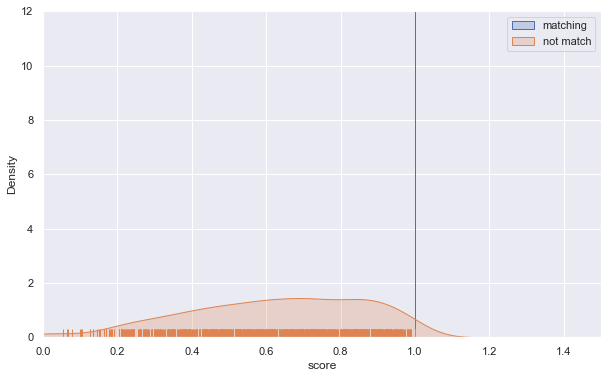

In [36]:
plt.figure(figsize=(10,6))
# plt.subplot(121)
sb.distplot(df_match_neg.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# plt.subplot(121)
# sb.distplot(df_top5_neg.score, label = 'top5_relevance')
# plt.subplot(121)
sb.distplot(df_no_neg.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
plt.xlim([0, 1.5])
plt.ylim([0, 12])
plt.legend()
# plt.title('Distribution of Consine Similarity score')
plt.show()

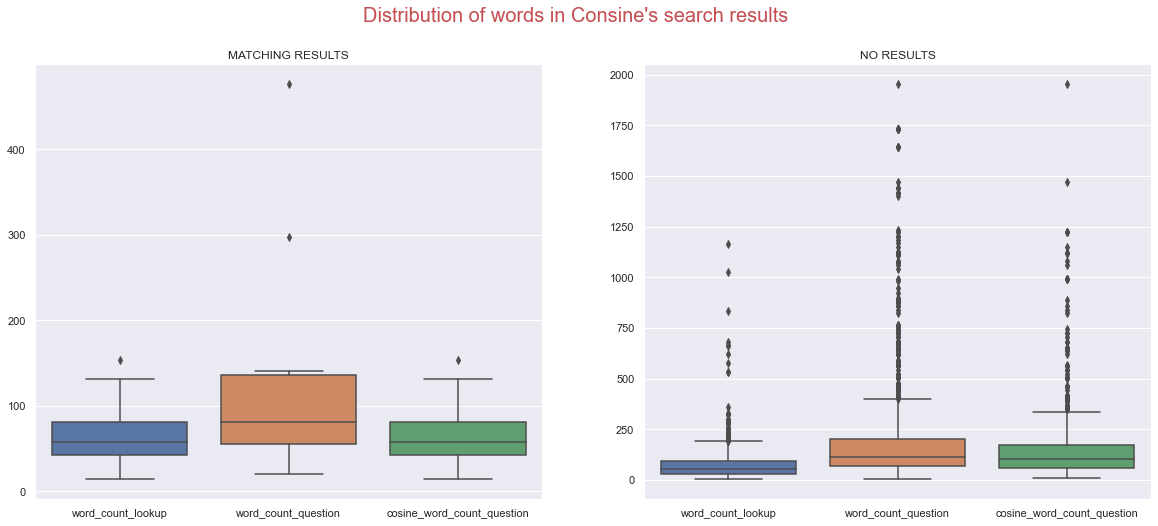

In [37]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.boxplot(data = df_match_neg[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.boxplot(data = df_no_neg[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']])
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Consine's search results", fontsize = 20, color = 'r');

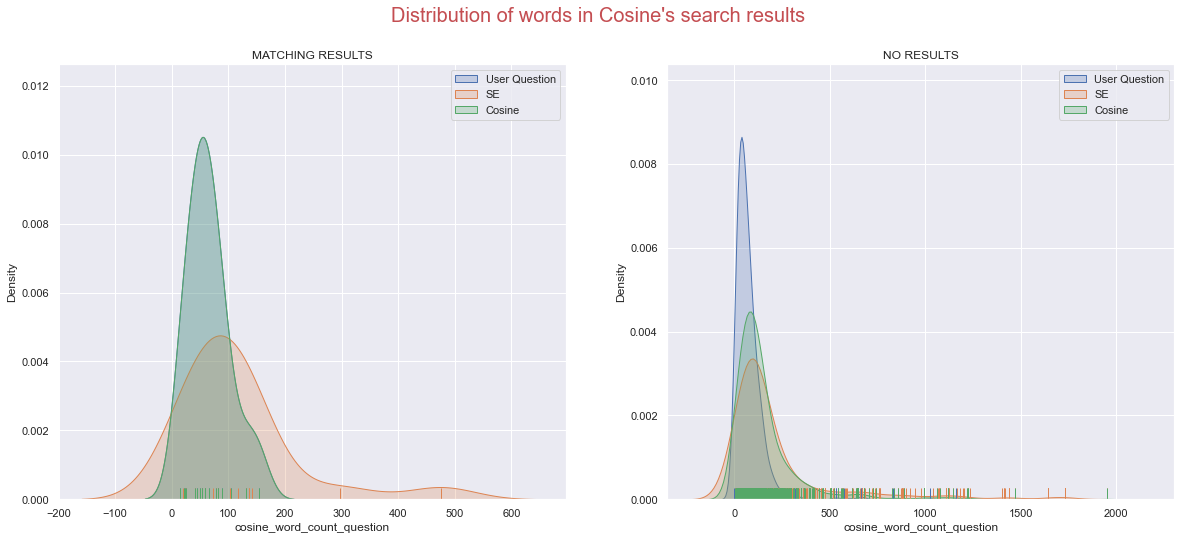

In [38]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.distplot(df_match_neg.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "User Question")
sb.distplot(df_match_neg.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "SE")
sb.distplot(df_match_neg.cosine_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "Cosine")
plt.legend()
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.distplot(df_no_neg.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "User Question")
sb.distplot(df_no_neg.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "SE")
sb.distplot(df_no_neg.cosine_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "Cosine")
plt.legend()
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Cosine's search results", fontsize = 20, color = 'r')
plt.show()

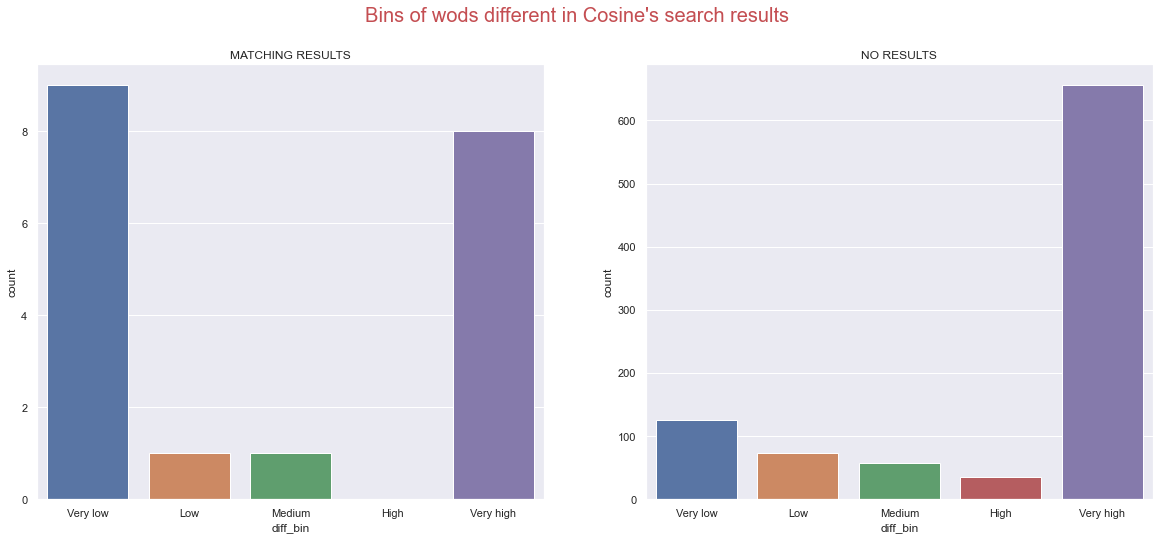

In [39]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_match_neg['diff_bin'])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.countplot(df_no_neg['diff_bin'])
plt.title('NO RESULTS')
plt.suptitle("Bins of wods different in Cosine's search results", fontsize = 20, color = 'r');

# 3. Cosine search in MATCH Dataset

In [40]:
result_pos = cosine_search_all(df_pos['Lookup Text'], tf_pos, tfidf_matrix_pos, df_pos)

Time: 28.648020029067993


In [41]:
df_pos['search_result'] = result_pos['question_text']
df_pos['score'] = result_pos['sim_score']
df_pos['cosine_word_count_question'] = result_pos['cosine_word_count_question']
df_pos['cosine_diff_bin'] = result_pos['cosine_diff_bin']
df_pos['cosine_image'] = result_pos['cosine_image']

In [42]:
mask5 = df_pos['Question Text'] != df_pos['search_result']

df_check_pos = df_pos[mask5]
df_check_pos.shape

(103, 24)

In [43]:
def cosine_pos_noPCA(query, tf, tfidf_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    query = clean_function(query)
    query_tf = tf.transform([query])
    query_tf = pd.DataFrame(query_tf.toarray(),
                            columns = tf.get_feature_names())
    
    cosine_sim = cosine_similarity(query_tf, tfidf_matrix).flatten()
    
    related_question = cosine_sim.argsort()[-top_result:][::-1]
    
    cosine_sim = sorted(cosine_sim, reverse = True)
    similarities_score = cosine_sim[:top_result]
    
    result = pd.DataFrame({'question_text': data.iloc[related_question, :]['Question Text'].values,
                           'sim_score': similarities_score})
    if check_time:
        print('Time:', time() - t0)
    return result

In [44]:
def check_wrong_results(indices):
    index_ = df_check_pos.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = cosine_pos_noPCA(df_check_pos.iloc[num]['Lookup Text'], tf_pos, tfidf_matrix_pos, df_pos, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check_pos.iloc[num]['Lookup Text'] in top_results) or (df_check_pos.iloc[num]['Question Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

top5_result_pos, no_result_pos = check_wrong_results(list(range(0, len(df_check_pos.index))))

In [45]:
print(len(top5_result_pos))
print(len(no_result_pos))

61
42


In [46]:
mask6 = df_pos['Question Text'] == df_pos['search_result']

df_match_pos = df_pos[mask6]
df_match_pos.shape

(893, 24)

In [47]:
df_top5_pos = df_pos.iloc[top5_result_pos, :]
df_top5_pos.shape

(61, 24)

In [48]:
df_no_pos = df_pos.iloc[no_result_pos, :]
df_no_pos.shape

(42, 24)

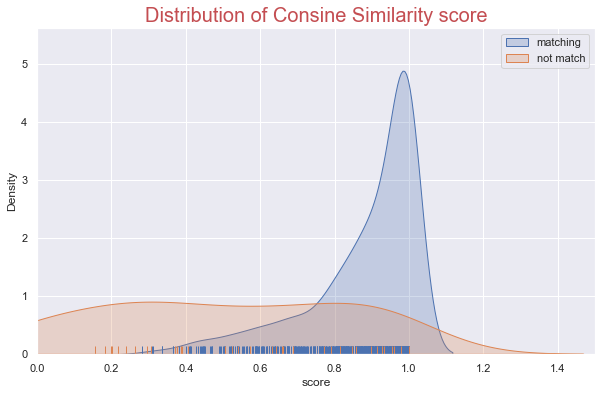

In [49]:
plt.figure(figsize=(10,6))
sb.distplot(df_match_pos.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
sb.distplot(df_no_pos.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
plt.xlim([0, 1.5])
# plt.ylim([0, 12])
plt.legend()
plt.title('Distribution of Consine Similarity score', fontsize = 20, color = 'r')
plt.show()

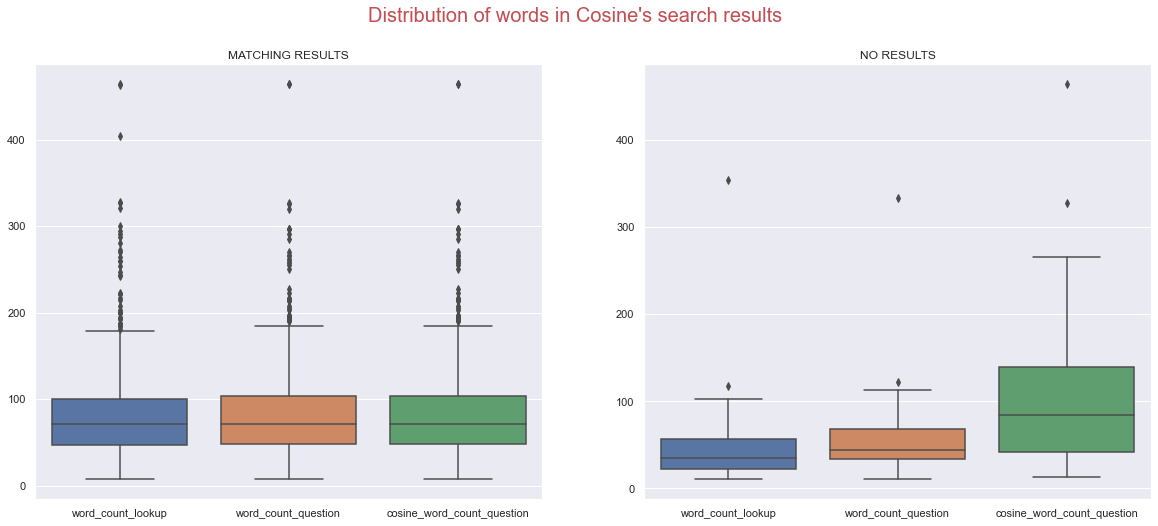

In [50]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.boxplot(data = df_match_pos[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.boxplot(data = df_no_pos[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']])
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Cosine's search results", fontsize = 20, color = 'r');

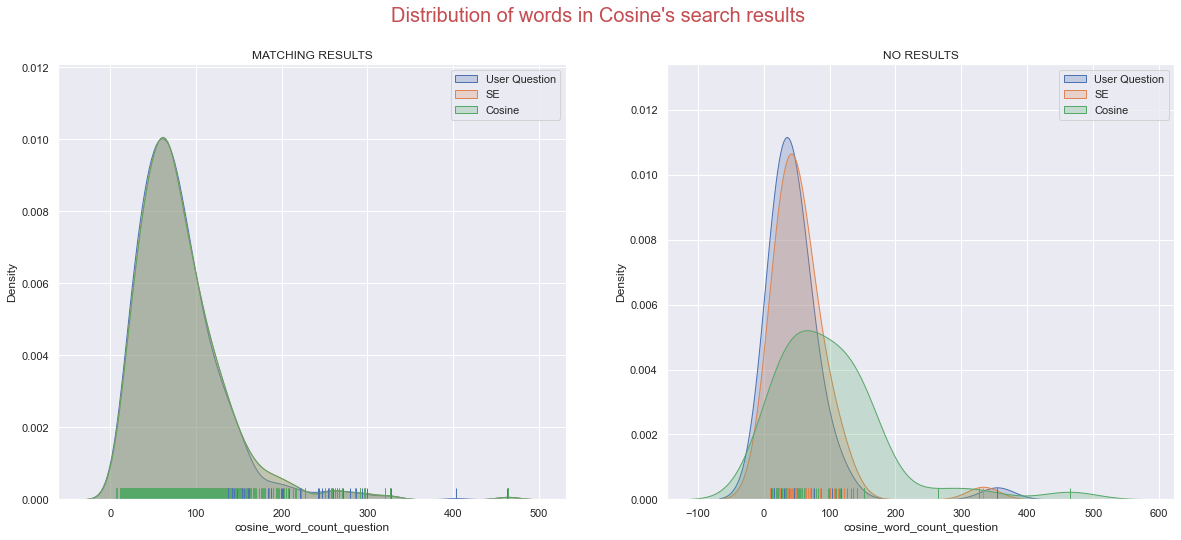

In [51]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.distplot(df_match_pos.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "User Question")
sb.distplot(df_match_pos.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "SE")
sb.distplot(df_match_pos.cosine_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "Cosine")
plt.legend()
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.distplot(df_no_pos.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "User Question")
sb.distplot(df_no_pos.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "SE")
sb.distplot(df_no_pos.cosine_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "Cosine")
plt.legend()
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Cosine's search results", fontsize = 20, color = 'r')
plt.show()

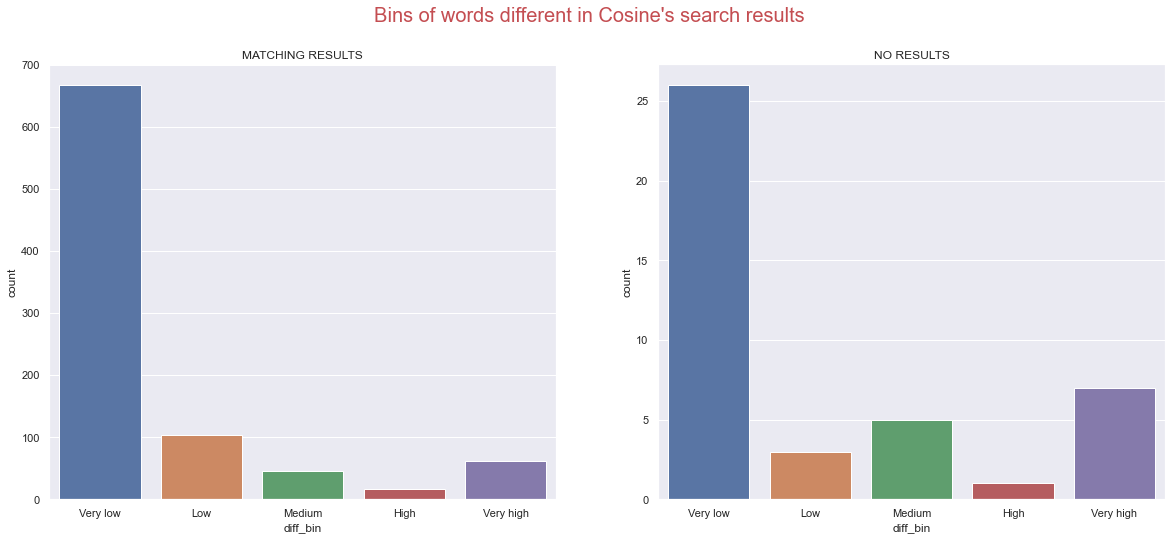

In [52]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_match_pos['diff_bin'])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.countplot(df_no_pos['diff_bin'])
plt.title('NO RESULTS')
plt.suptitle("Bins of words different in Cosine's search results", fontsize = 20, color = 'r');

# 4. Comparing

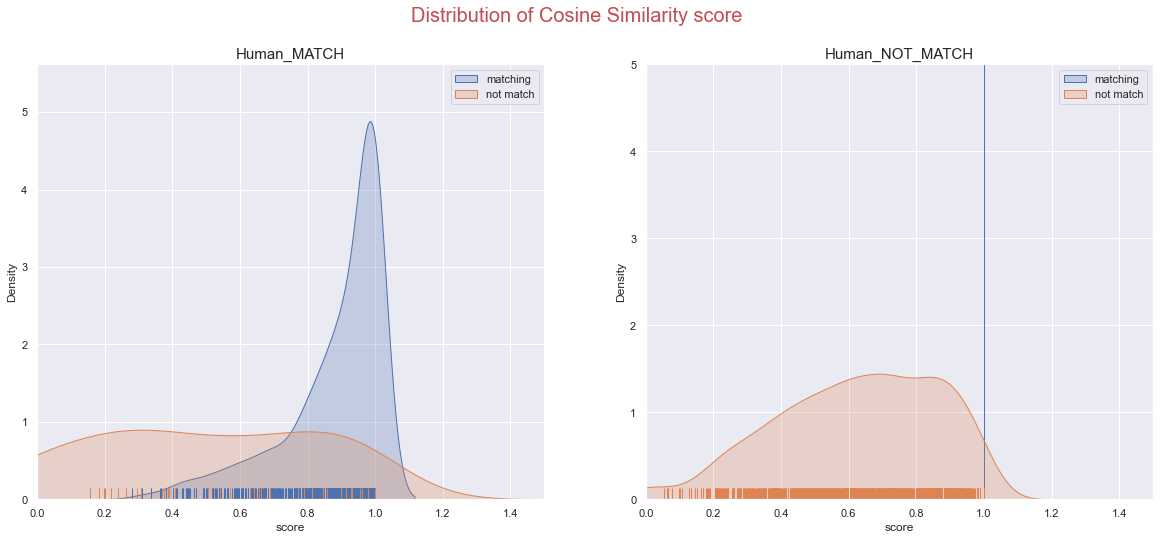

In [53]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sb.distplot(df_match_pos.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# sb.distplot(df_top5_neg.jc_score, label = 'top5_relevance')
sb.distplot(df_no_pos.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
plt.xlim([0, 1.5])
# plt.ylim([0, 12])
plt.legend()
plt.title('Human_MATCH', fontsize = 15)
plt.subplot(122)
sb.distplot(df_match_neg.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# sb.distplot(df_top5_neg.jc_score, label = 'top5_relevance')
sb.distplot(df_no_neg.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
plt.xlim([0, 1.5])
plt.ylim([0, 5])
plt.legend()
plt.title('Human_NOT_MATCH', fontsize = 15)
plt.suptitle('Distribution of Cosine Similarity score', fontsize = 20, color = 'r')
plt.show()

In [54]:
df_final = pd.DataFrame({'Group': ['Human_MATCH', 'Human_NOT_MATCH'],
                         'Matching': [df_match_pos.shape[0], df_match_neg.shape[0]],
                         'In top5': [df_top5_pos.shape[0], df_top5_neg.shape[0]],
                         'No result': [df_no_pos.shape[0], df_no_neg.shape[0]]})
df_final

Group  Matching  In top5  No result
0      Human_MATCH       893       61         42
1  Human_NOT_MATCH        19        0        947

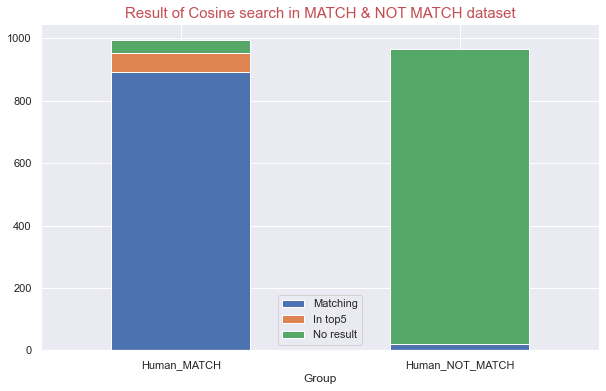

In [55]:
plt.rcParams["figure.figsize"] = [10, 6]
df_final.plot.bar(x = 'Group', stacked = True, rot = 0)
plt.legend()
plt.title('Result of Cosine search in MATCH & NOT MATCH dataset', fontsize = 15, color = 'r');

In [67]:
df_sum1 = pd.DataFrame({'Algorithms': ['Cosine', 'Gensim', 'Jaccard'],
                       'Matching': [893, 933, 957],
                       'In top5': [61, 49, 37],
                       'No results': [42, 14, 2]})
df_sum1

Algorithms  Matching  In top5  No results
0     Cosine       893       61          42
1     Gensim       933       49          14
2    Jaccard       957       37           2

In [68]:
df_sum2 = pd.DataFrame({'Algorithms': ['Cosine', 'Gensim', 'Jaccard'],
                       'Matching': [19, 19, 19],
                       'In top5': [0, 0, 0],
                       'No results': [947, 947, 947]})
df_sum2

Algorithms  Matching  In top5  No results
0     Cosine        19        0         947
1     Gensim        19        0         947
2    Jaccard        19        0         947

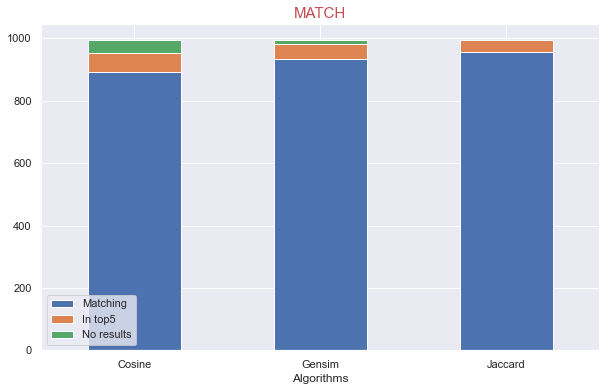

In [79]:
plt.rcParams["figure.figsize"] = [10, 6]
df_sum1.plot.bar(x = 'Algorithms', stacked = True, rot = 0)
plt.legend()
plt.title('MATCH', fontsize = 15, color = 'r');

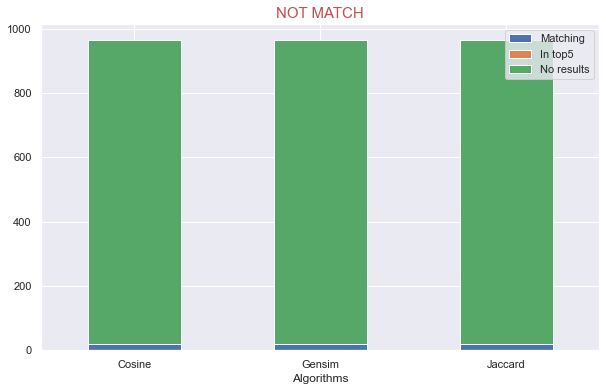

In [74]:
plt.rcParams["figure.figsize"] = [10, 6]
df_sum2.plot.bar(x = 'Algorithms', stacked = True, rot = 0)
plt.legend()
plt.title('NOT MATCH', fontsize = 15, color = 'r');

In [56]:
df_no_pos.head()

Feedback ID                                        Lookup Text  \
12        4496.0  \( \sqrt{3} \sin x+\cos x+\cos 5 x+2(\cos 6 x+...   
24        4543.0  Câu 37. Hàm số nào đồng biến trên khoảng \( (-...   
54        4674.0                       \( 2 x-2^{0}=3^{5}: 3^{3} \)   
95        4926.0  Fer 1\na) \( x^{2}\left(5 x^{2}-x-\frac{1}{2}\...   
122       5061.0  Câu 17. Trong mặt phẳng \( Oxy \) cho \( \over...   

                                         Question Text Feedback Type  \
12   Đề 117: Giải phương trình: \( \sqrt{3} \sin (x...      NEGATIVE   
24   D. Hàm số nghịh bich trểa caic kên khoảng \( (...      NEGATIVE   
54                     f) \( 2 x-2^{0}=3^{5}: 3^{3} \)      POSITIVE   
95   1. Làm tính nhân :\na) \( x^{2}\left(5 x^{3}-x...      NEGATIVE   
122  Câu 3: Trong mát phẳng toa đô \( O n y \), cho...      NEGATIVE   

    Feedback Result Human Feedback  \
12        NOT_MATCH          MATCH   
24            MATCH          MATCH   
54        NOT_MATCH          MATCH   
95        NOT_MATCH          MATCH   
122           MATCH          MATCH   

                                          Lookup Image  \
12   https://s3.icankid.io/uploads/question/bb4ed6f...   
24   https://s3.icankid.io/uploads/question/f9190b3...   
54   https://s3.icankid.io/uploads/question/90ea4e0...   
95   https://s3.icankid.io/uploads/question/ab47cdc...   
122  https://s3.icankid.io/uploads/question/bbf8f61...   

                                        Question Image  index_org  \
12   https://s3.icankid.io/uploads/question/bc6bb8a...         31   
24   https://s3.icankid.io/uploads/question/9600bf5...         50   
54   https://s3.icankid.io/uploads/question/91a64b0...         99   
95   https://s3.icankid.io/uploads/question/3be66f0...        176   
122  https://s3.icankid.io/uploads/question/f5c9947...        224   

                                          clean_lookup  ...  \
12   \ ( \ sqrt { 3_}_\ sin x + \ cos x + \ cos 5 x...  ...   
24   câu 37 . hàm_số nào đồng_biến trên khoảng \ ( ...  ...   
54       \ ( 2 x-2 ^_{ 0 } = 3 ^ { 5 } : 3 ^ { 3 }_\ )  ...   
95   fer 1 a ) \ ( x ^ { 2 }_\_left ( 5 x ^ { 2 } -...  ...   
122  câu 17 . trong mặt_phẳng \ ( oxy_\ ) cho \ ( \...  ...   

    char_count_question  word_count_question  average_word_length_question  \
12                  134                   43                      3.116279   
24                  226                   72                      3.138889   
54                   49                   22                      2.227273   
95                   97                   33                      2.939394   
122                 296                  106                      2.792453   

     diff_word  diff_bin                                      search_result  \
12           7       Low  15) \( \sqrt{3} \cos 5 x-2 \sin 3 x \cdot \cos...   
24           4  Very low  Câu 13. Tập họp tất cả các giá trị của tham số...   
54           2  Very low  Ví dụ 3: Cho tam giác \( A B C \). Gọi \( M , ...   
95           1  Very low  Bài 2.4. Tìm các số hữu tỉ \( x \) biết:\na) \...   
122          5  Very low  Câu 5: Trong mặt phằng \( Oxy \) cho hàm số \(...   

        score  cosine_word_count_question cosine_diff_bin  \
12   0.845979                          28        Very low   
24   0.657468                          98        Very low   
54        0.0                         153             Low   
95   0.955045                         135        Very low   
122  0.571943                          61          Medium   

                                          cosine_image  
12   https://s3.icankid.io/uploads/question/c56b0de...  
24   https://s3.icankid.io/uploads/question/fbb5626...  
54   https://s3.icankid.io/uploads/question/0eb8801...  
95   https://s3.icankid.io/uploads/question/8e3296f...  
122  https://s3.icankid.io/uploads/question/8f4b4f3...  

[5 rows x 24 columns]

PAIRS: 1 - Cosine score: 1.0
-- Number of words: 57


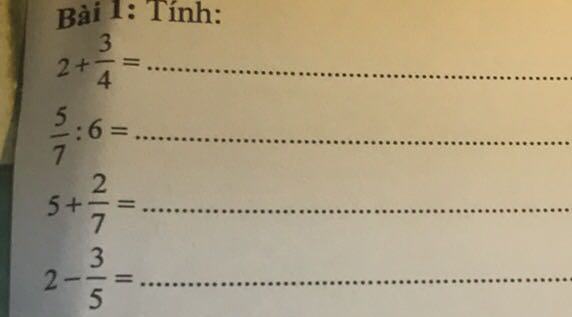

-- Number of words: 75


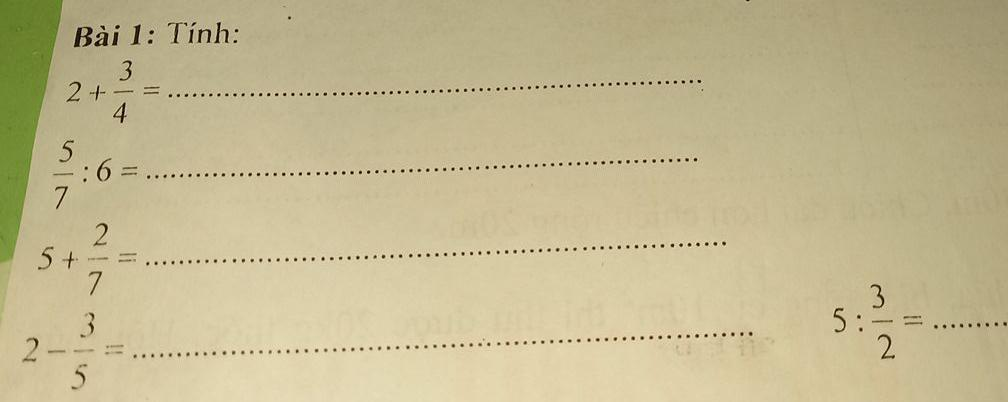

-- Number of words: 19


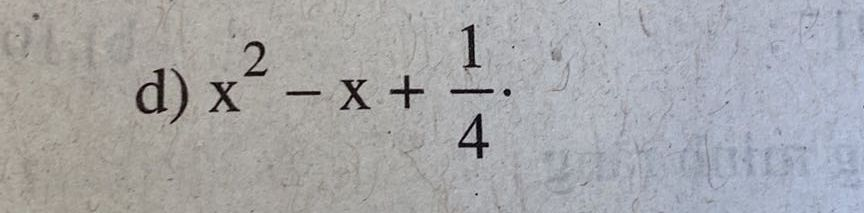

************
PAIRS: 2 - Cosine score: 0.9787222683732149
-- Number of words: 28


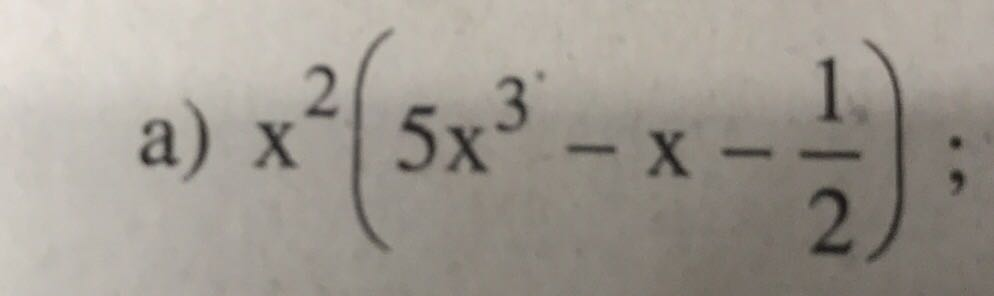

-- Number of words: 33


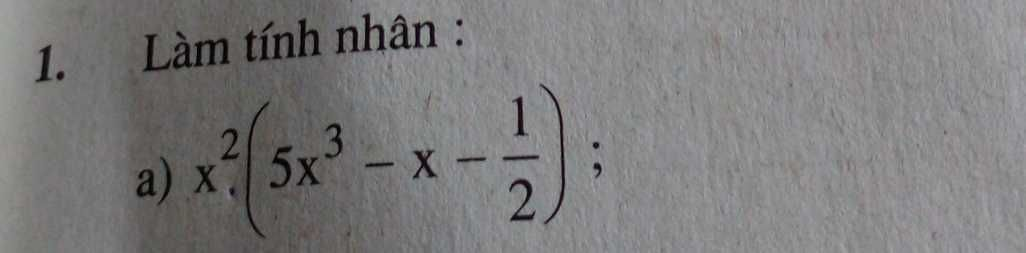

-- Number of words: 141


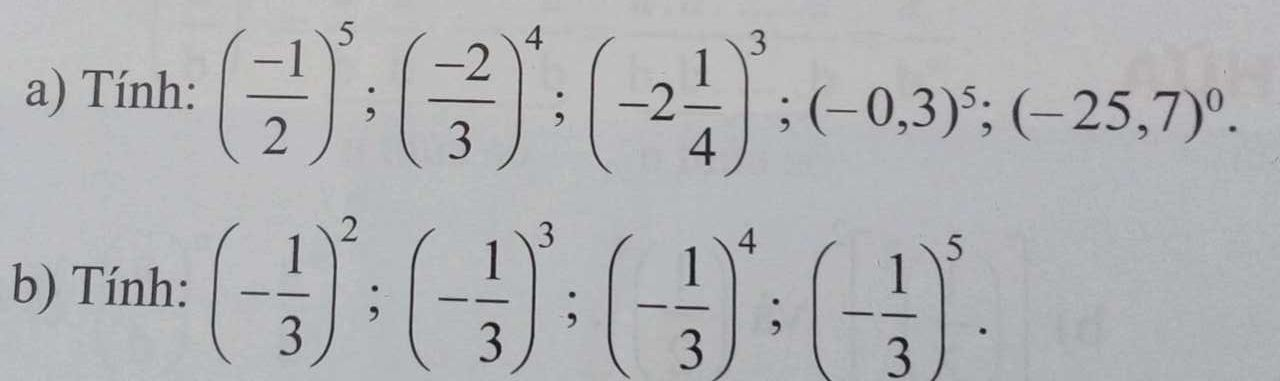

************
PAIRS: 3 - Cosine score: 0.9609482439186658
-- Number of words: 31


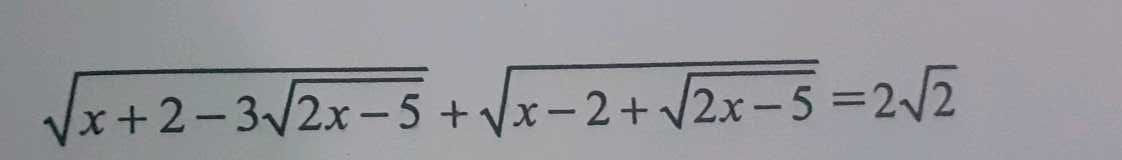

-- Number of words: 33


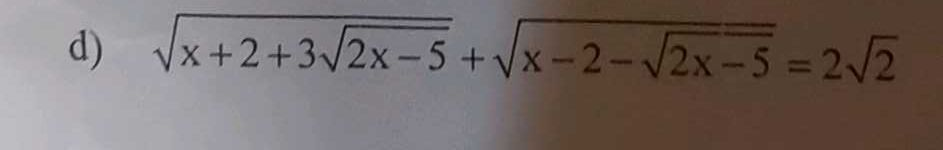

-- Number of words: 72


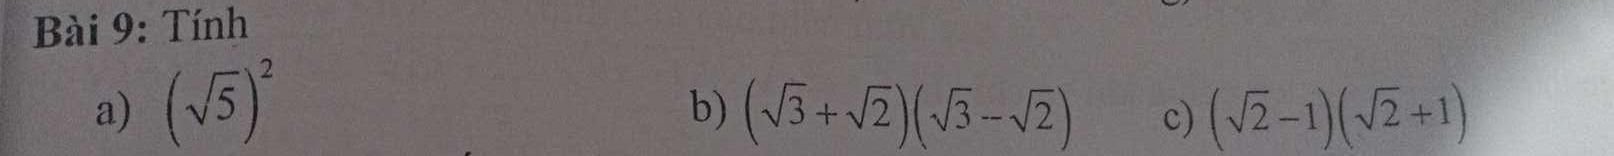

************
PAIRS: 4 - Cosine score: 0.9550454002157973
-- Number of words: 32


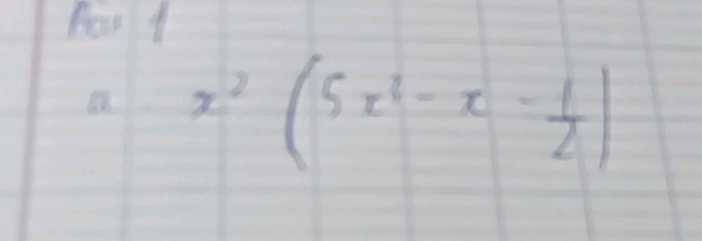

-- Number of words: 33


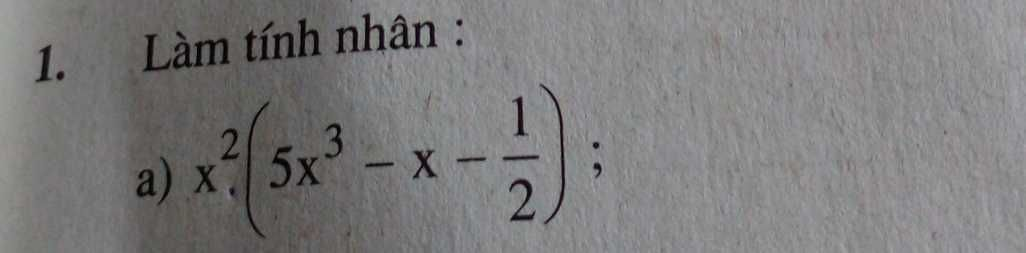

-- Number of words: 135


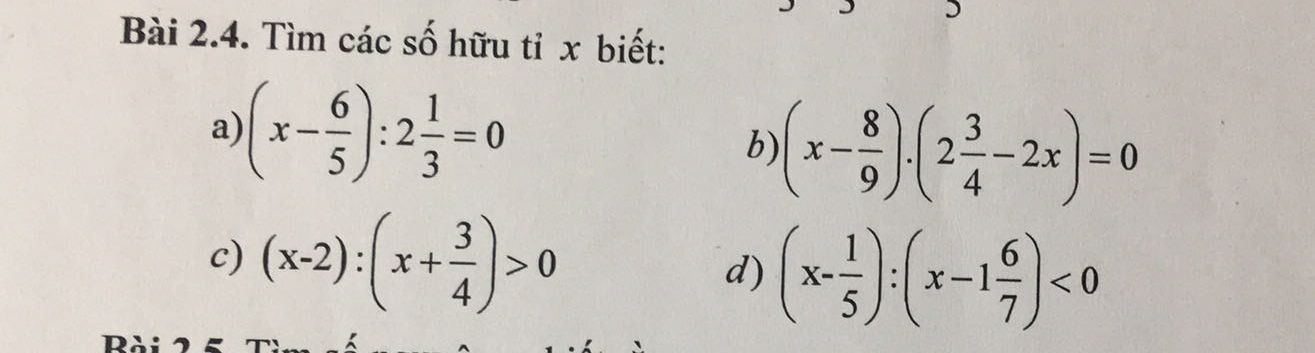

************
PAIRS: 5 - Cosine score: 0.931866649500068
-- Number of words: 117


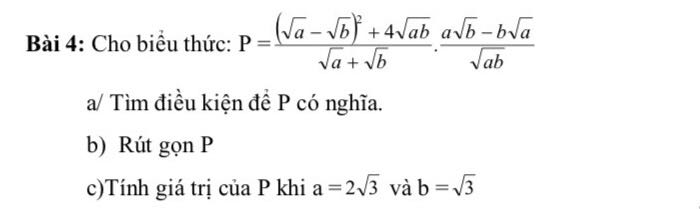

-- Number of words: 113


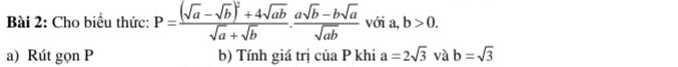

-- Number of words: 34


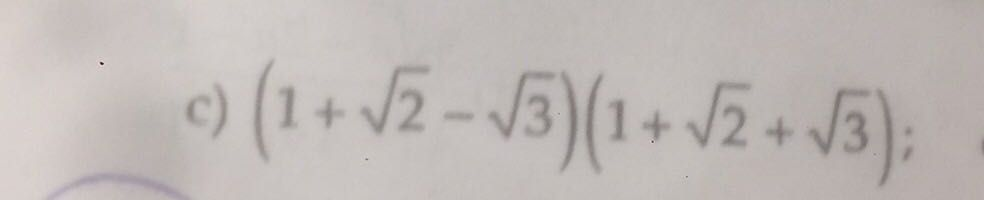

************
PAIRS: 6 - Cosine score: 0.9271840921703562
-- Number of words: 54


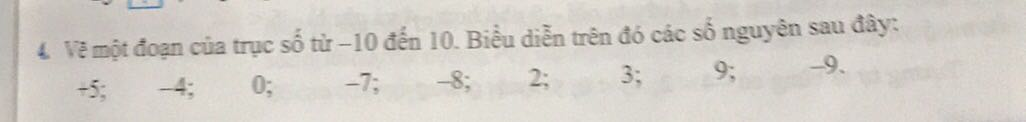

-- Number of words: 67


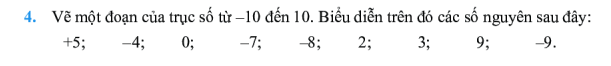

-- Number of words: 55


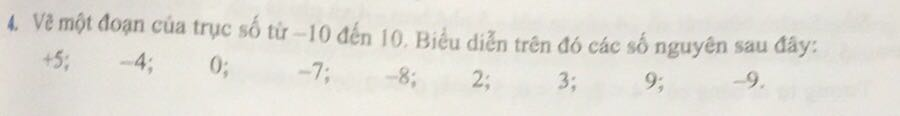

************
PAIRS: 7 - Cosine score: 0.9143450594594957
-- Number of words: 50


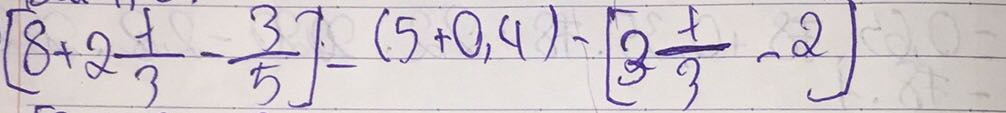

-- Number of words: 49


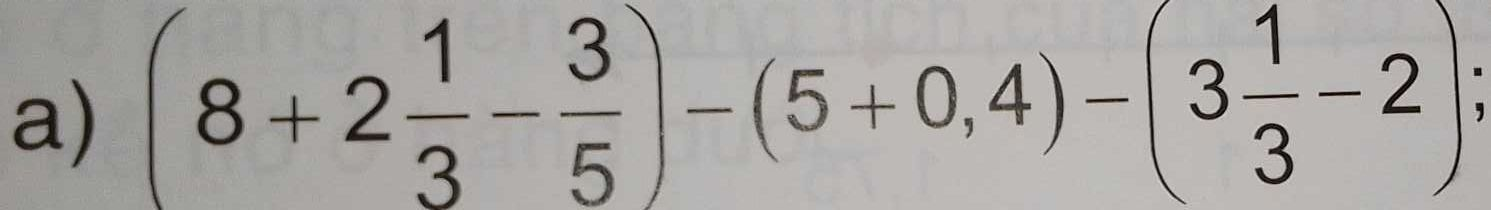

-- Number of words: 327


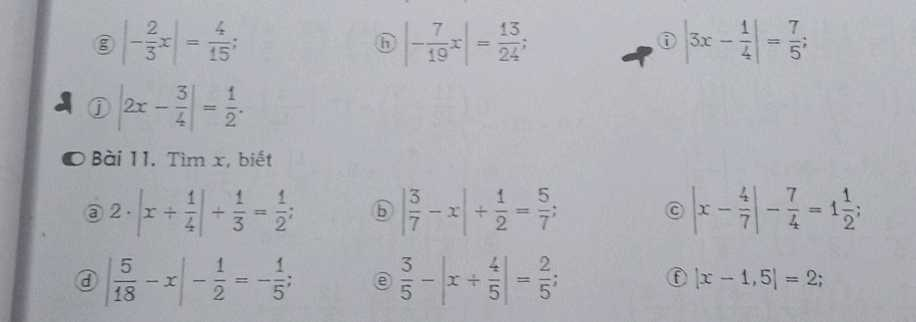

************
PAIRS: 8 - Cosine score: 0.8986826575553395
-- Number of words: 46


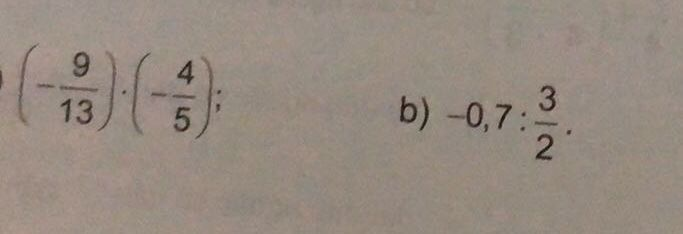

-- Number of words: 57


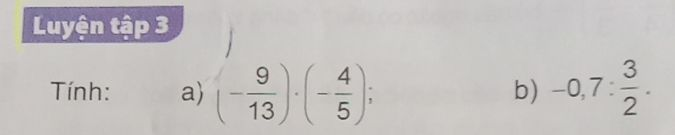

-- Number of words: 464


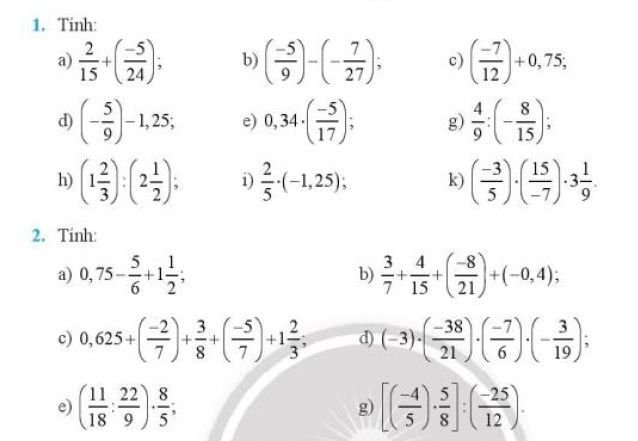

************
PAIRS: 9 - Cosine score: 0.8577477047607243
-- Number of words: 64


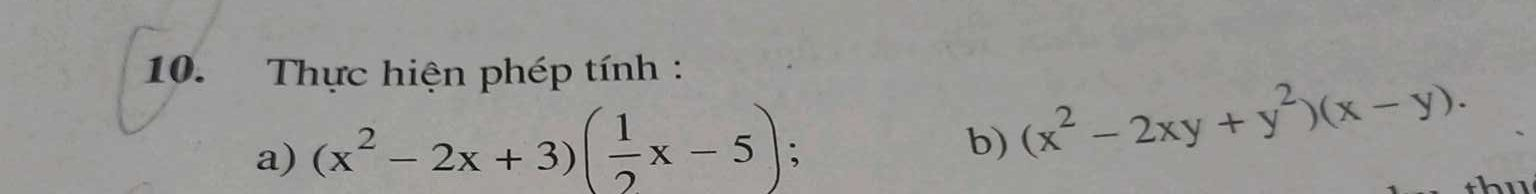

-- Number of words: 65


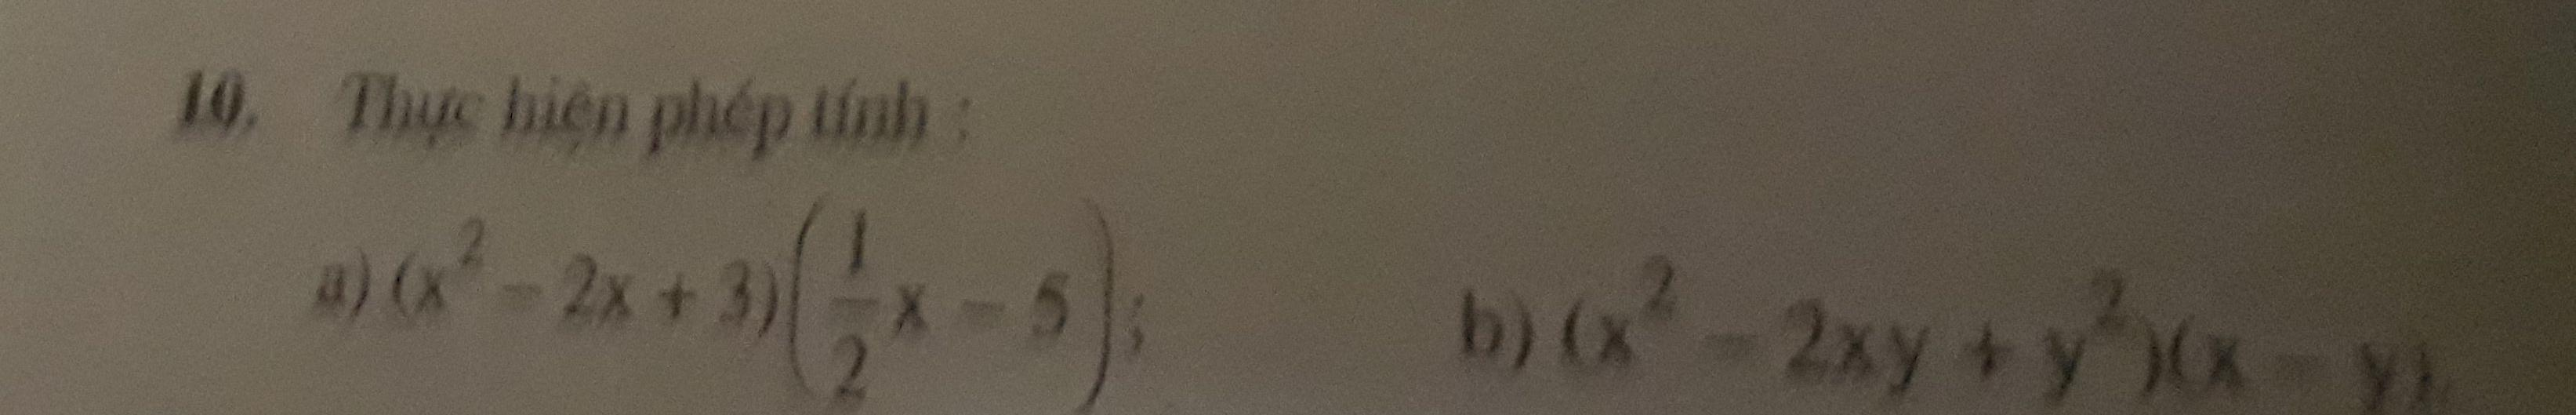

-- Number of words: 28


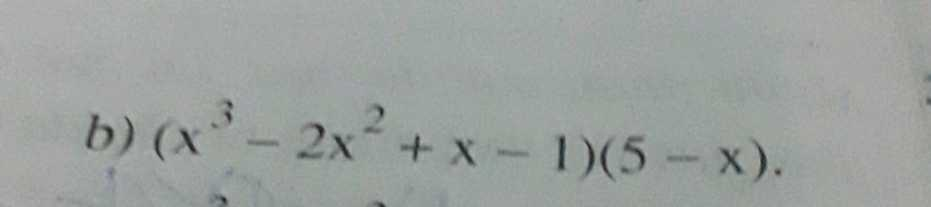

************
PAIRS: 10 - Cosine score: 0.8459793666472135
-- Number of words: 36


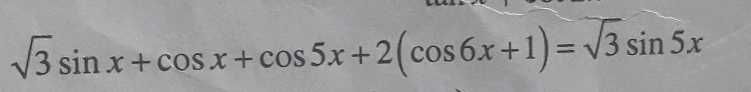

-- Number of words: 43


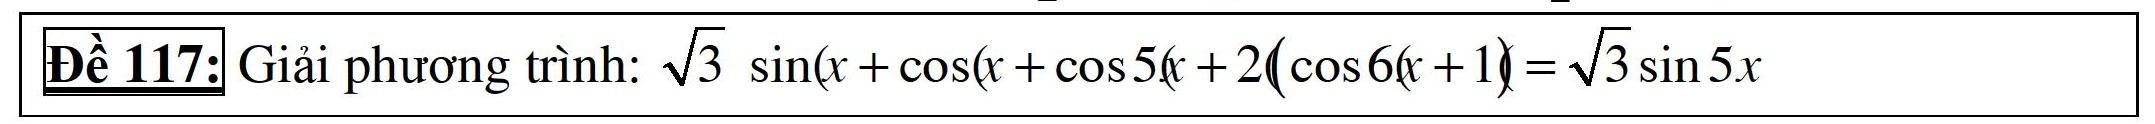

-- Number of words: 28


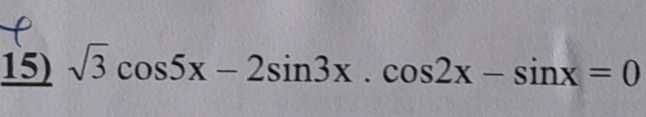

************
PAIRS: 11 - Cosine score: 0.8143354899459878
-- Number of words: 16


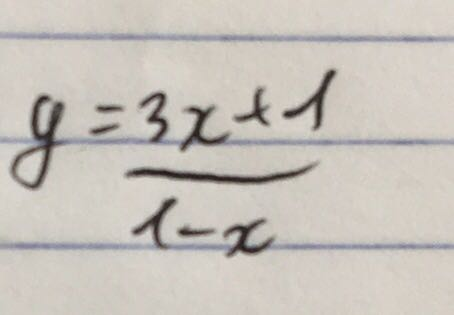

-- Number of words: 29


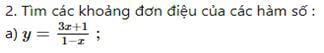

-- Number of words: 87


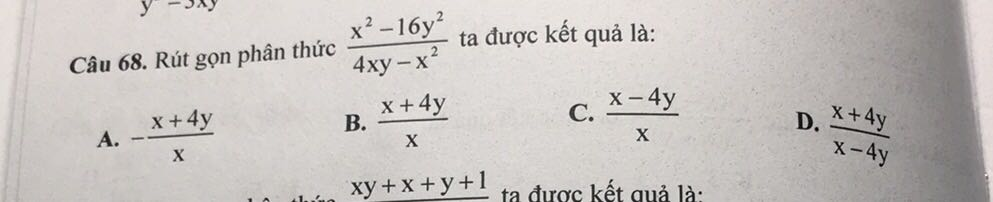

************
PAIRS: 12 - Cosine score: 0.7895588611803817
-- Number of words: 47


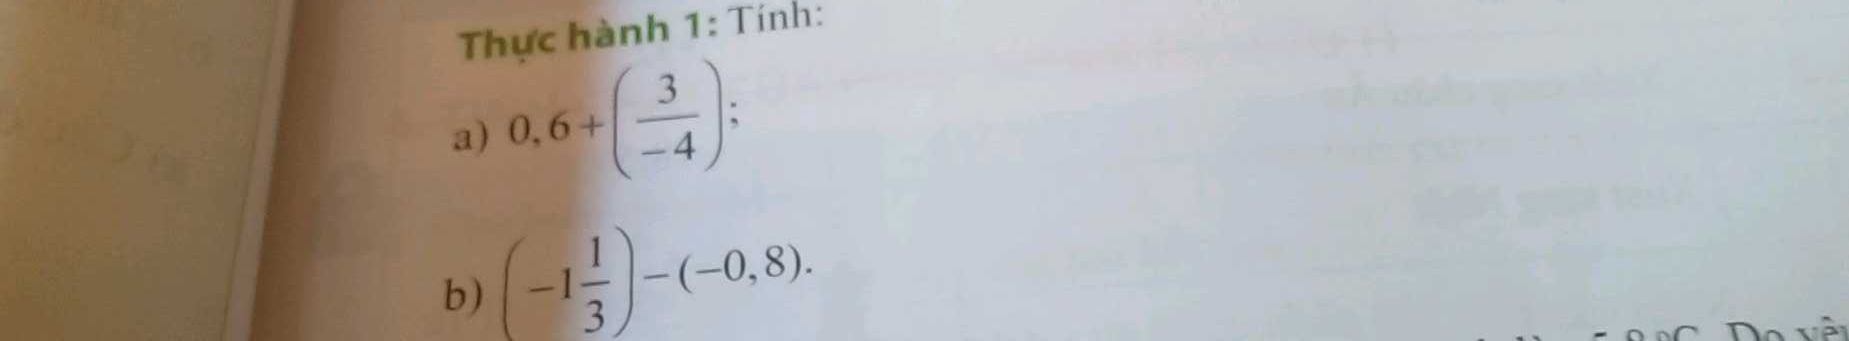

-- Number of words: 47


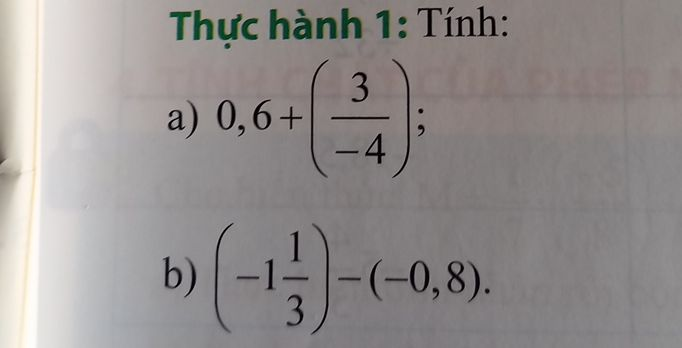

-- Number of words: 141


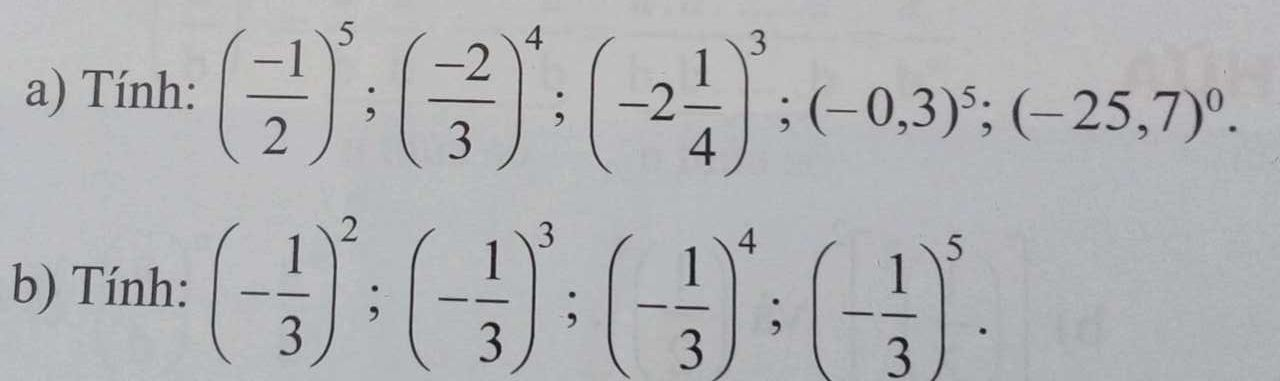

************
PAIRS: 13 - Cosine score: 0.772249789042522
-- Number of words: 354


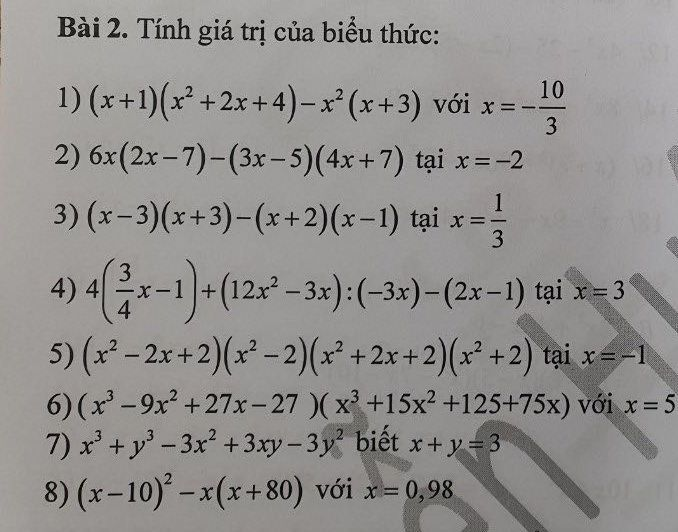

-- Number of words: 333


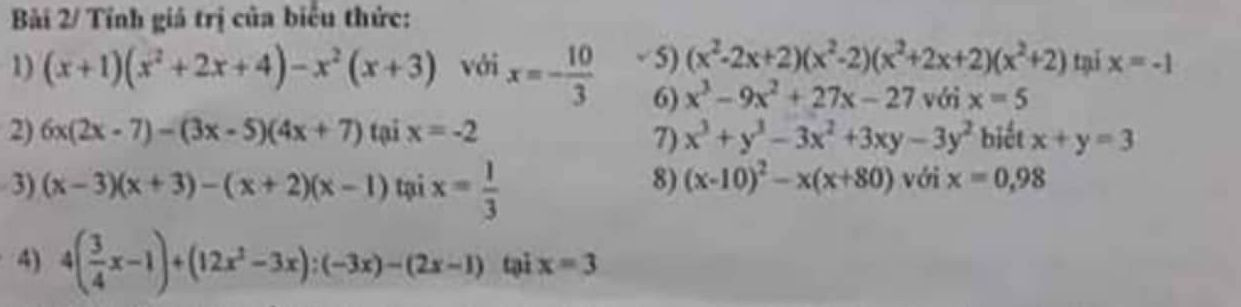

-- Number of words: 53


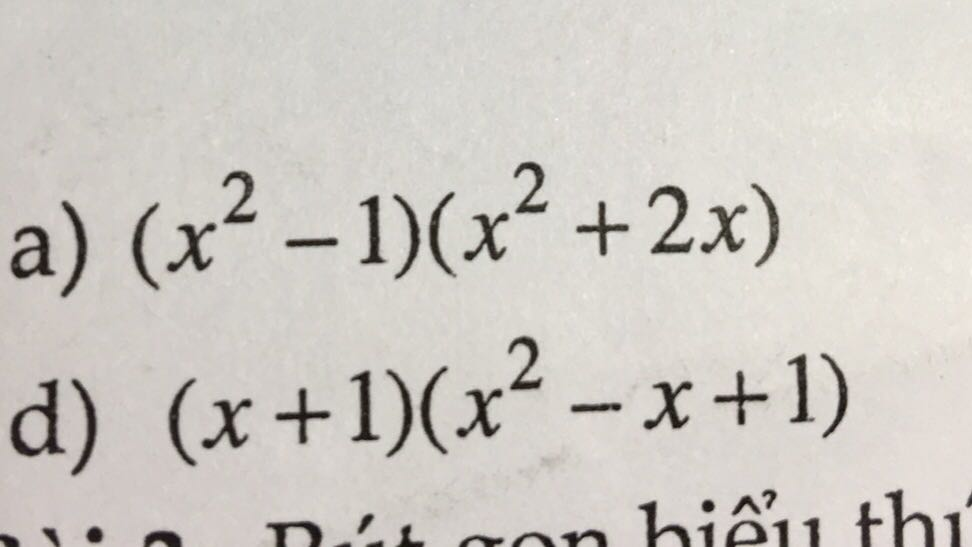

************
PAIRS: 14 - Cosine score: 0.6880359701484786
-- Number of words: 38


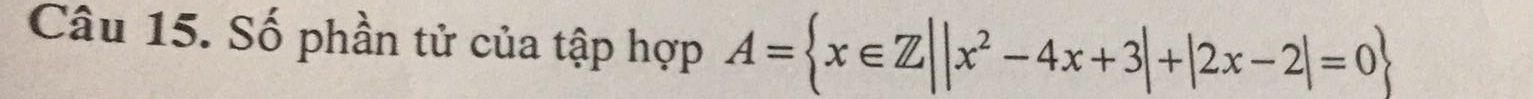

-- Number of words: 41


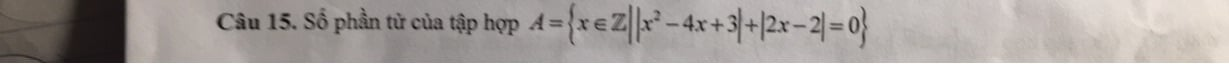

-- Number of words: 116


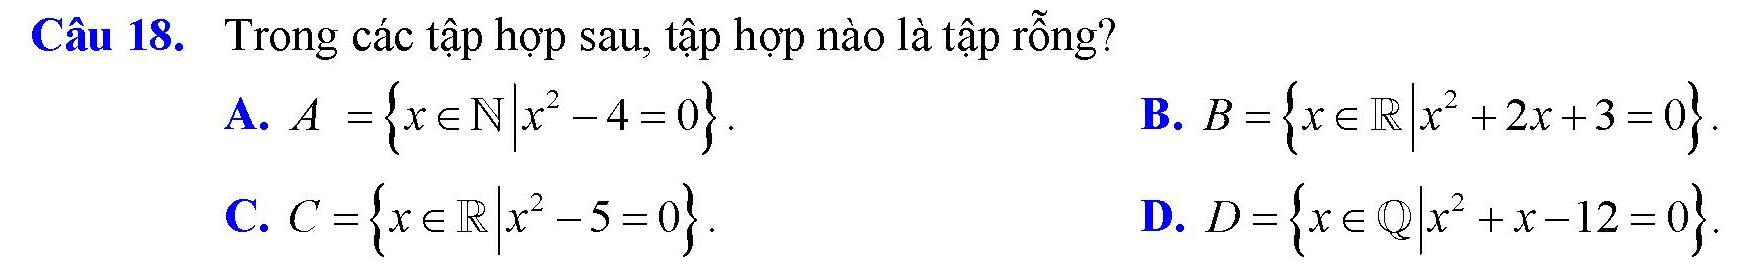

************
PAIRS: 15 - Cosine score: 0.6618609459342946
-- Number of words: 56


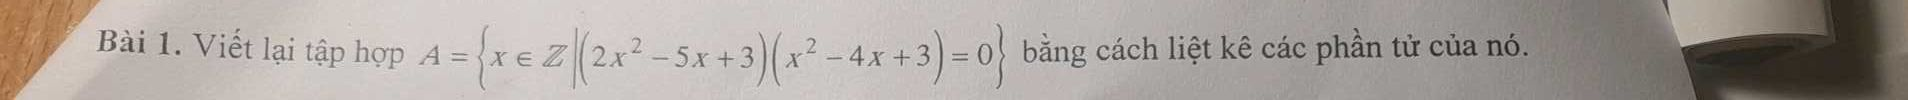

-- Number of words: 71


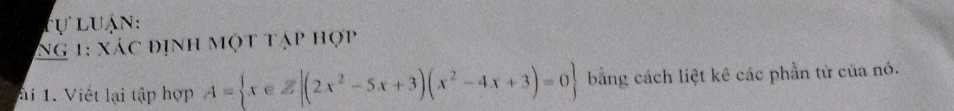

-- Number of words: 110


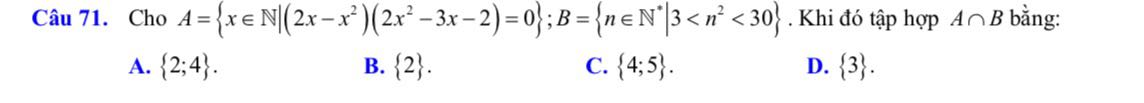

************
PAIRS: 16 - Cosine score: 0.657467601956653
-- Number of words: 76


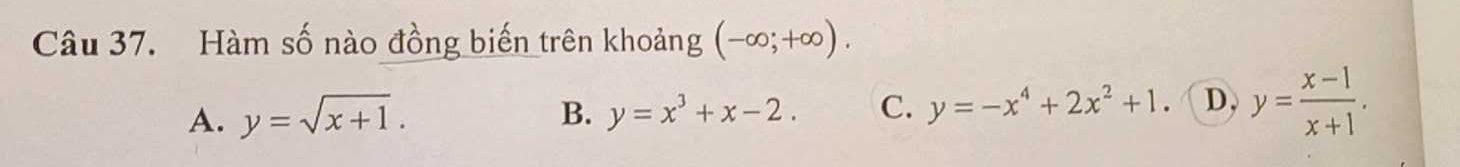

-- Number of words: 72


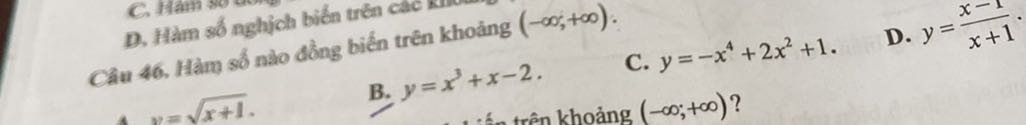

-- Number of words: 98


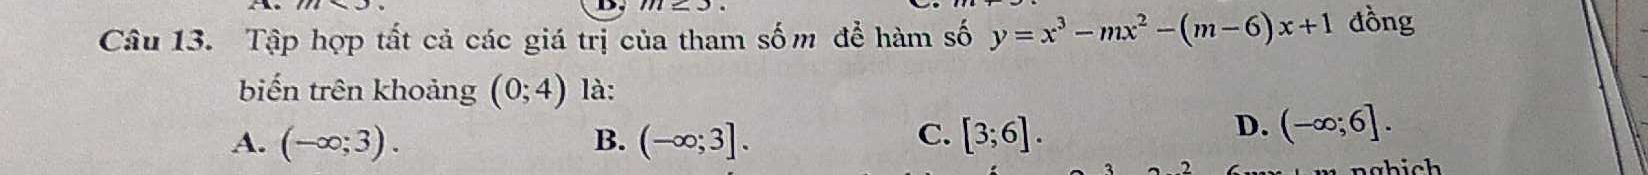

************
PAIRS: 17 - Cosine score: 0.6419794838160588
-- Number of words: 33


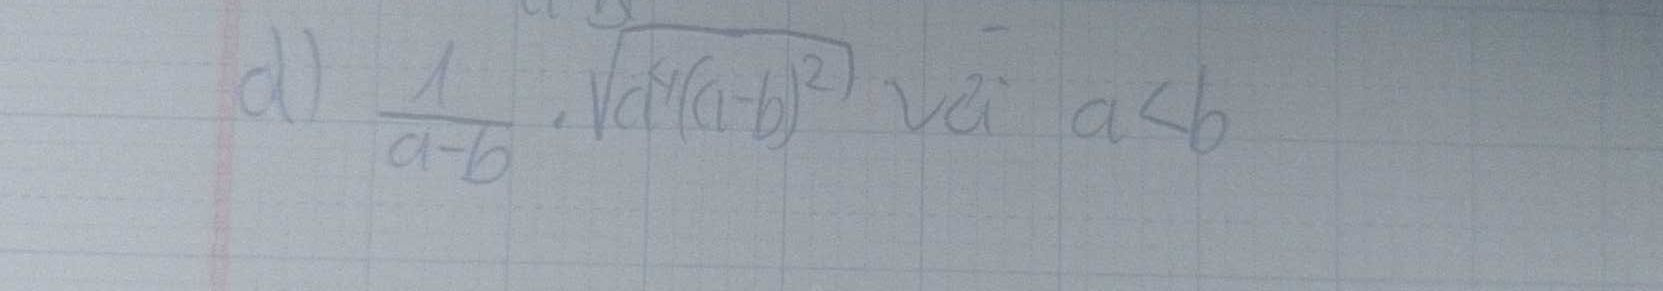

-- Number of words: 36


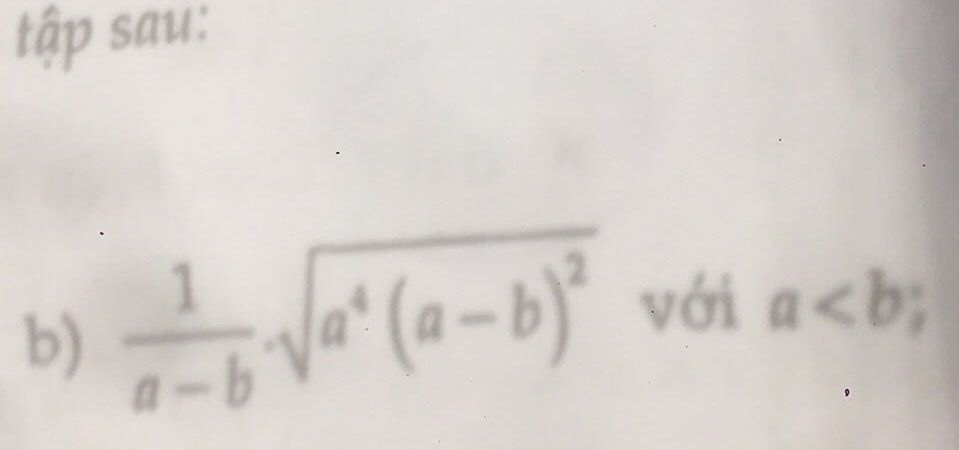

-- Number of words: 126


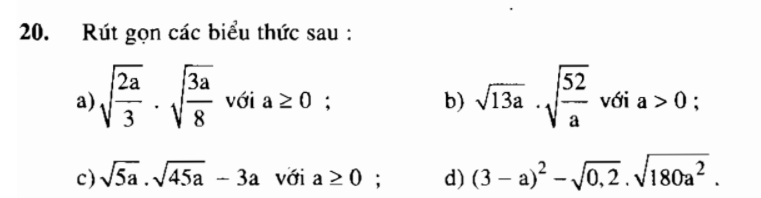

************
PAIRS: 18 - Cosine score: 0.6309642960903346
-- Number of words: 103


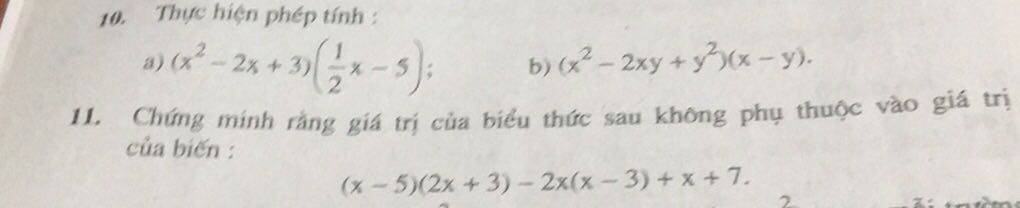

-- Number of words: 100


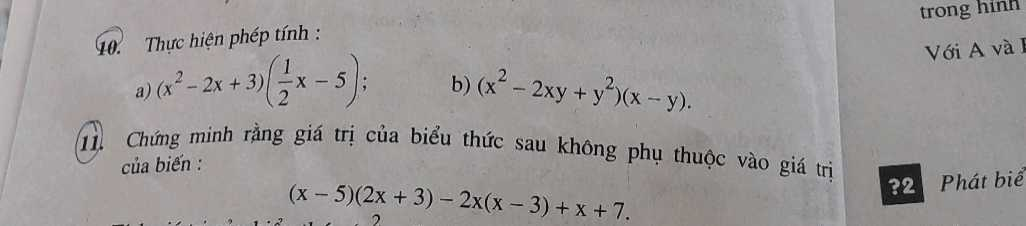

-- Number of words: 28


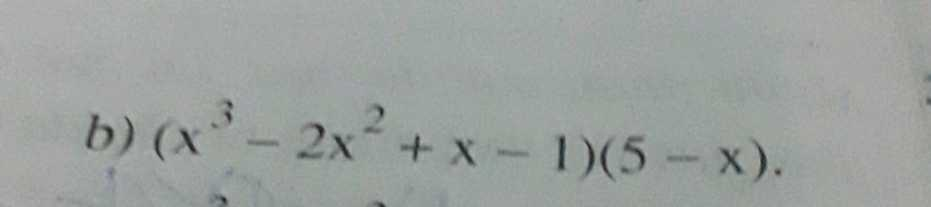

************
PAIRS: 19 - Cosine score: 0.5719431348097175
-- Number of words: 101


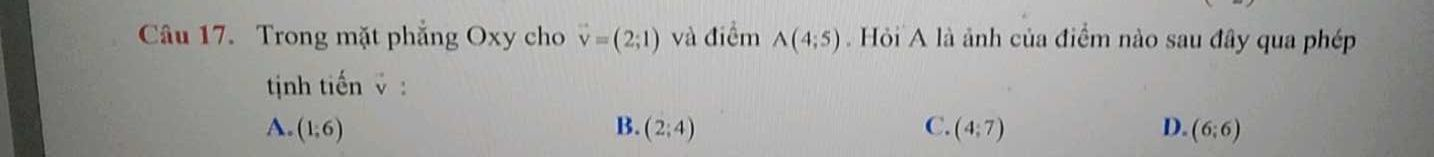

-- Number of words: 106


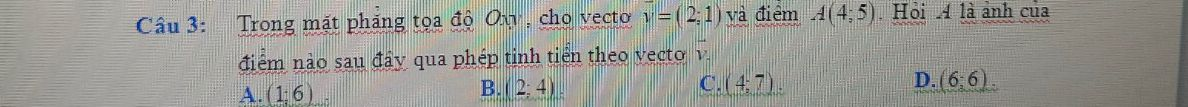

-- Number of words: 61


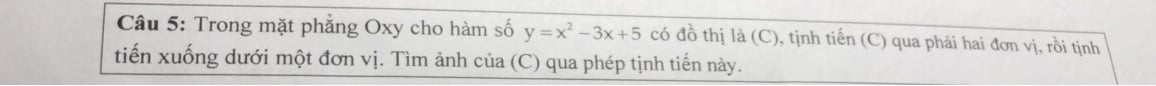

************
PAIRS: 20 - Cosine score: 0.539950538014283
-- Number of words: 12


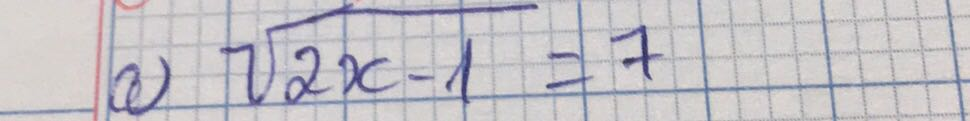

-- Number of words: 45


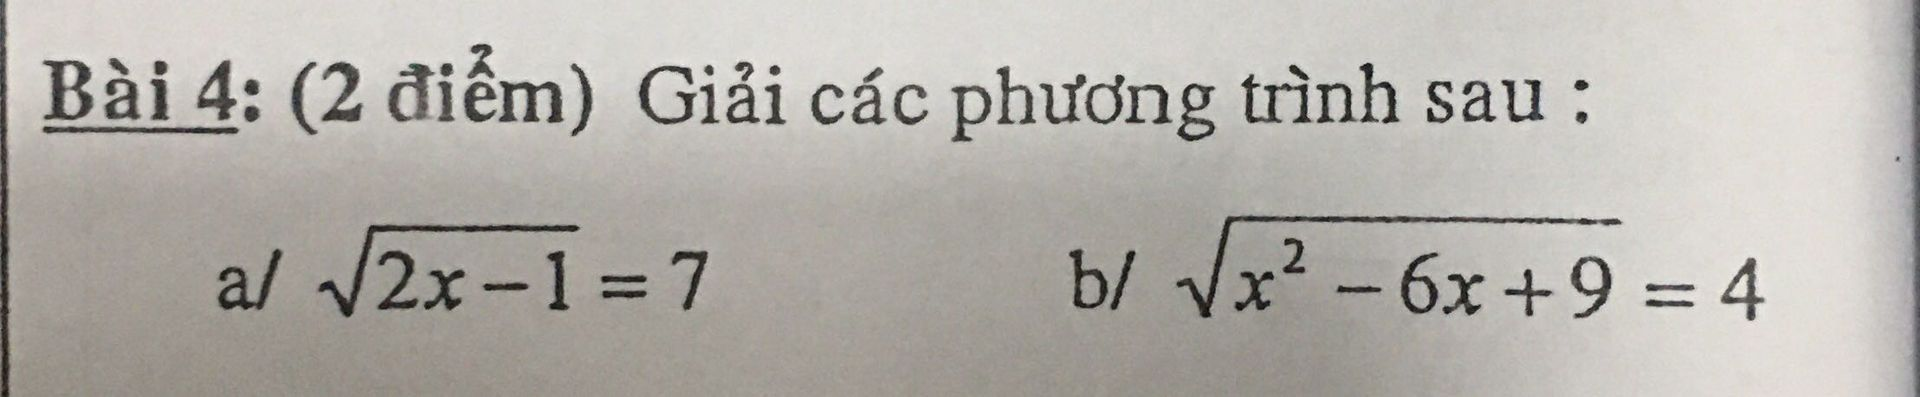

-- Number of words: 13


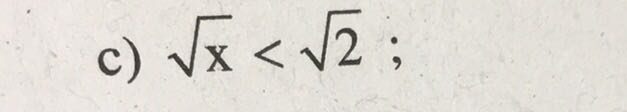

************
PAIRS: 21 - Cosine score: 0.5232114081039138
-- Number of words: 72


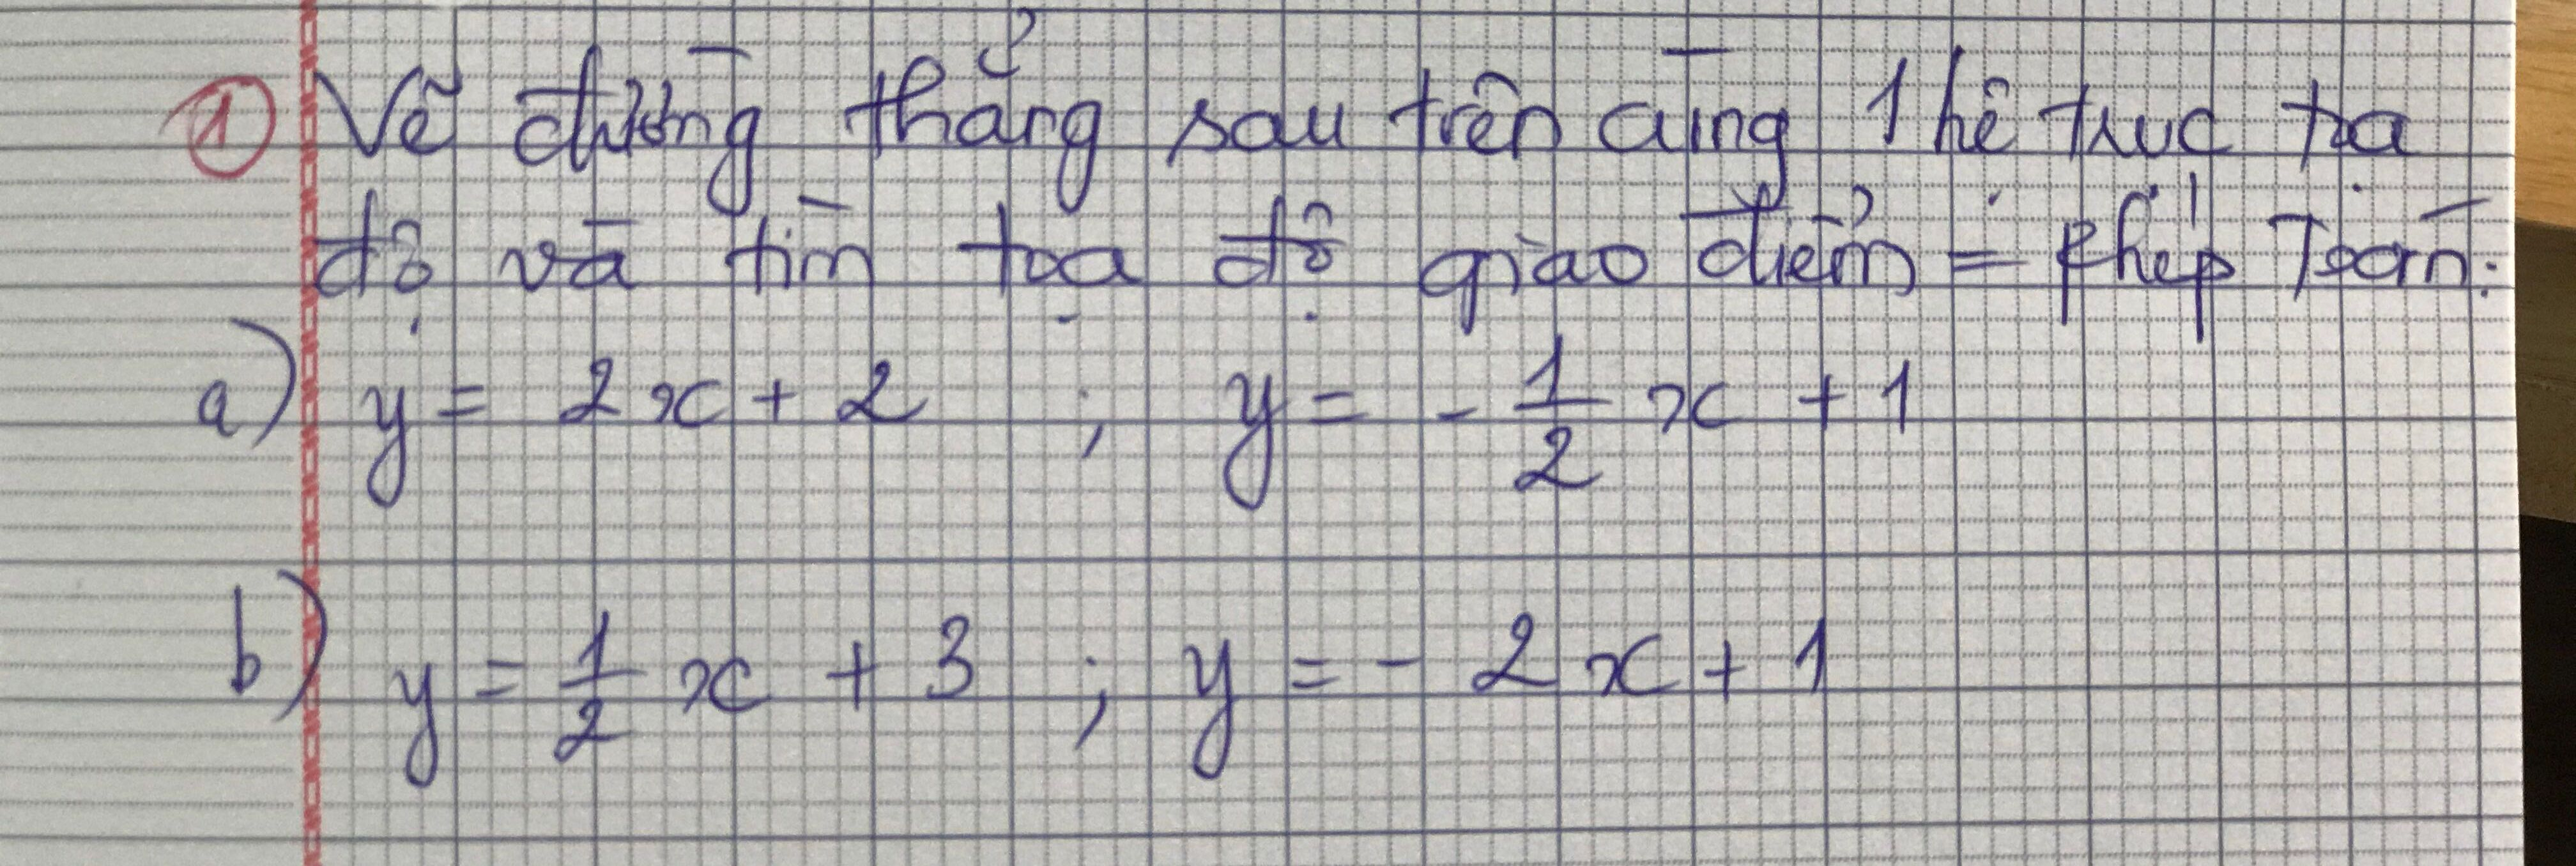

-- Number of words: 85


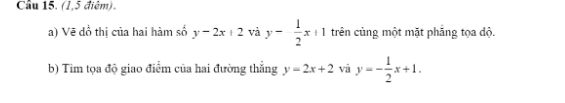

-- Number of words: 51


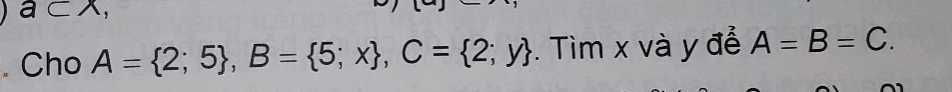

************
PAIRS: 22 - Cosine score: 0.5053195668171999
-- Number of words: 33


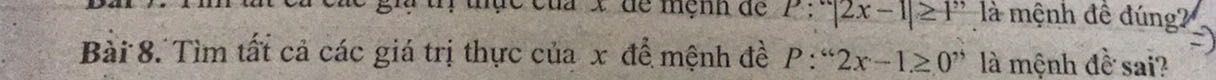

-- Number of words: 36


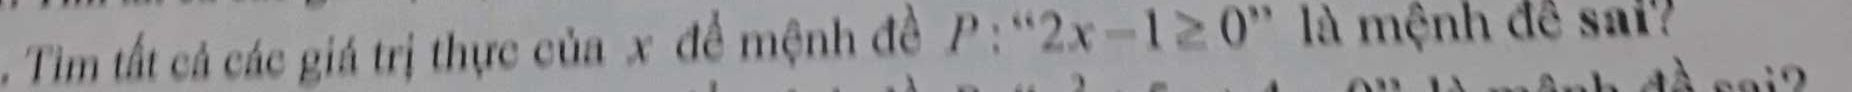

-- Number of words: 265


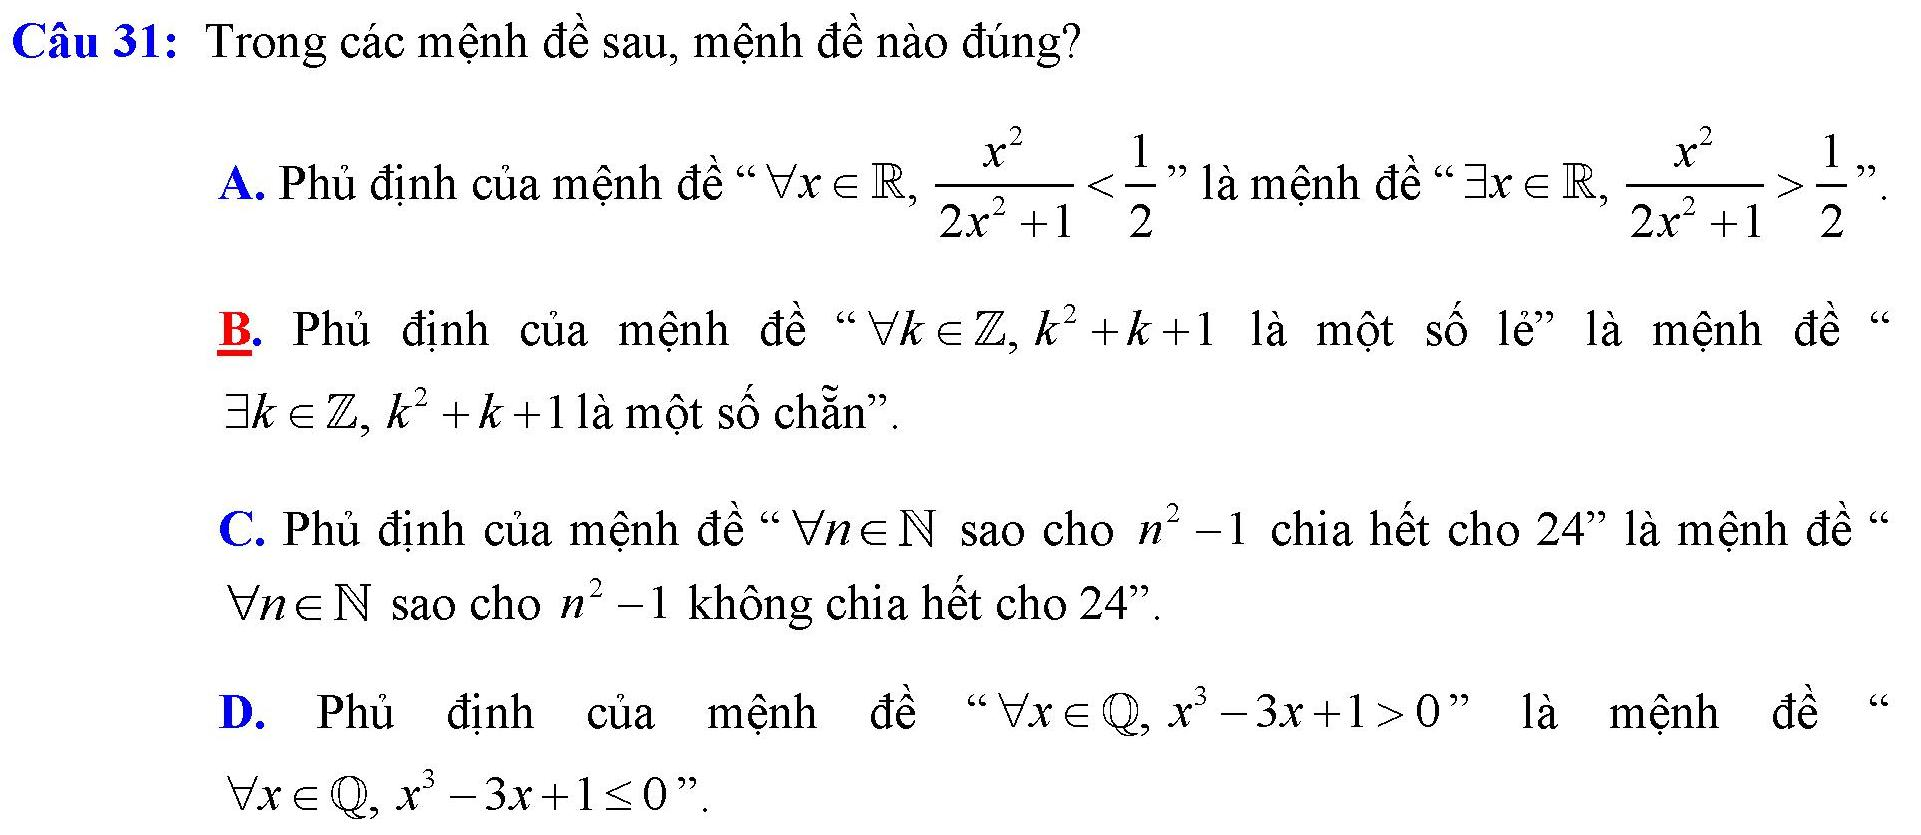

************
PAIRS: 23 - Cosine score: 0.40694942588640176
-- Number of words: 15


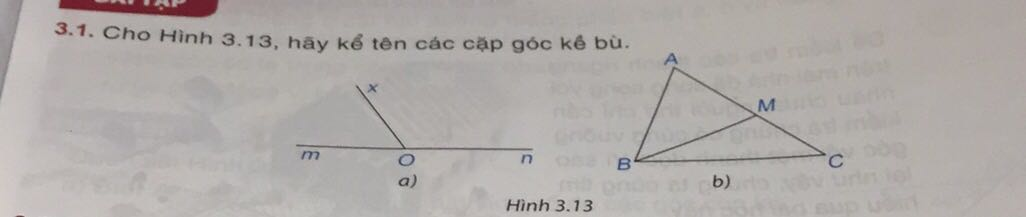

-- Number of words: 13


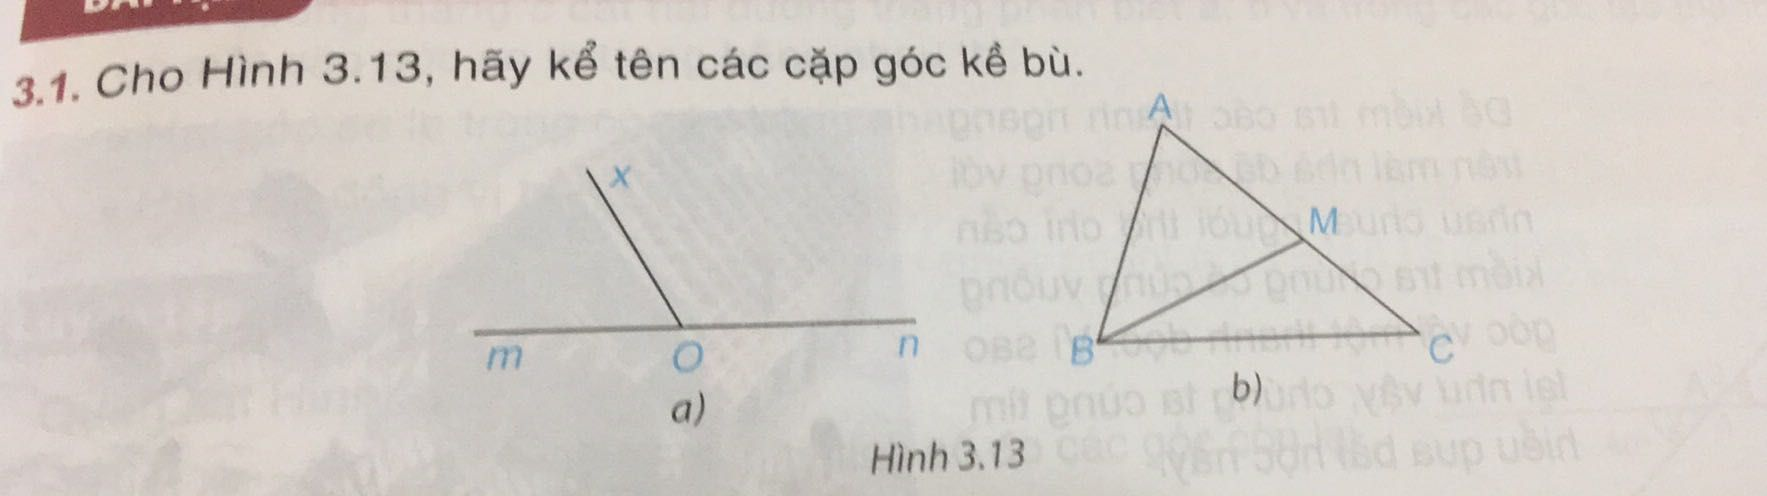

-- Number of words: 22


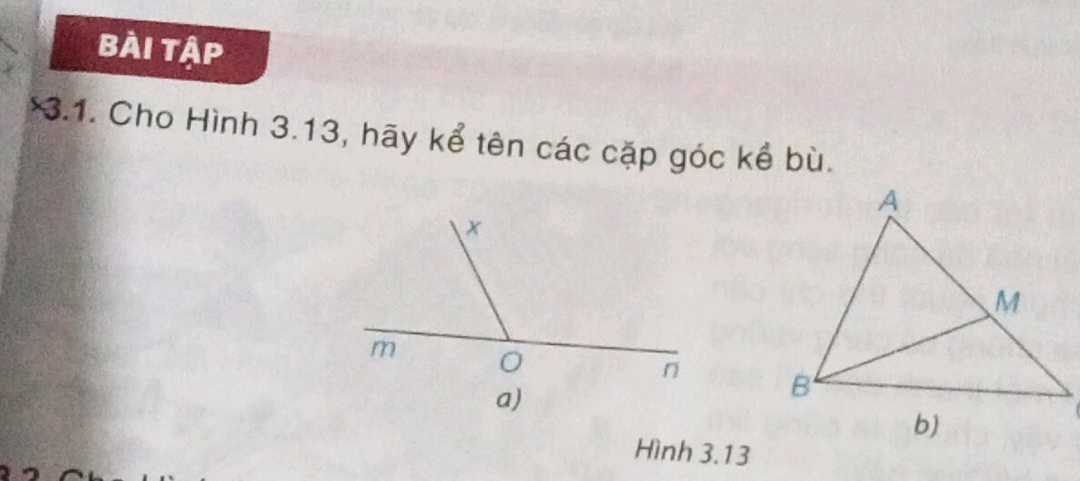

************
PAIRS: 24 - Cosine score: 0.3910905769294328
-- Number of words: 11


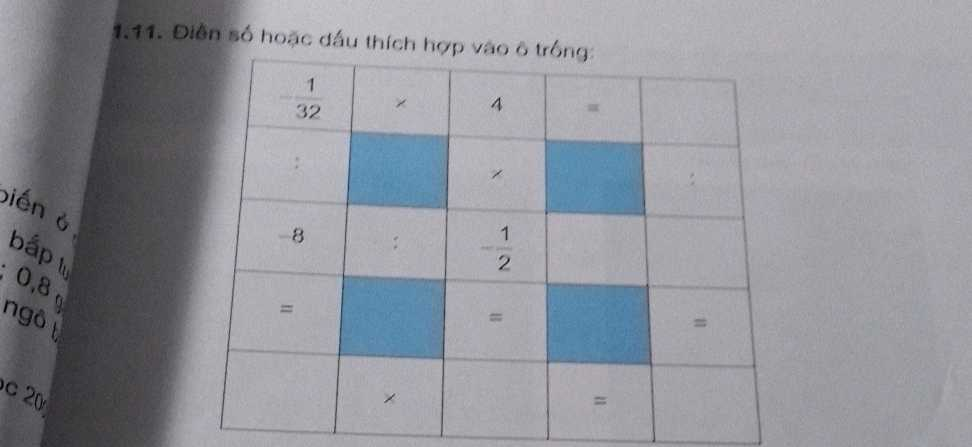

-- Number of words: 10


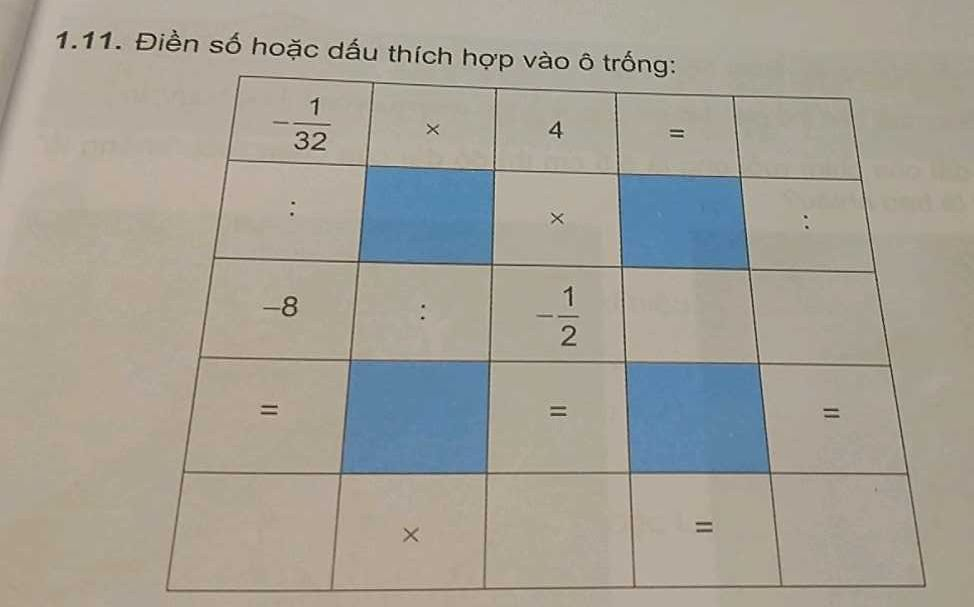

-- Number of words: 20


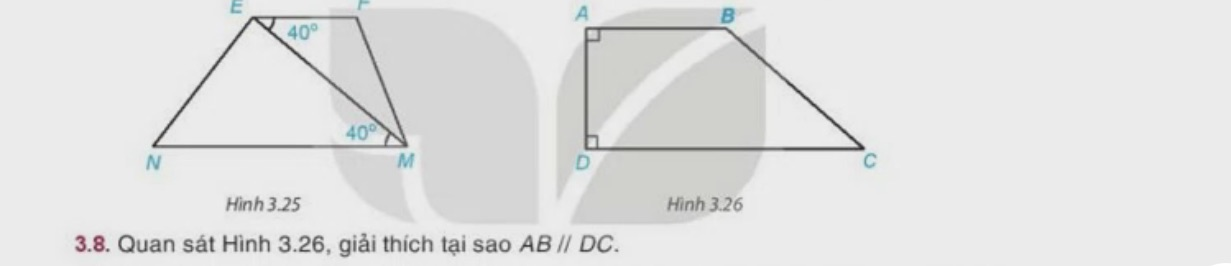

************
PAIRS: 25 - Cosine score: 0.38629849834043795
-- Number of words: 45


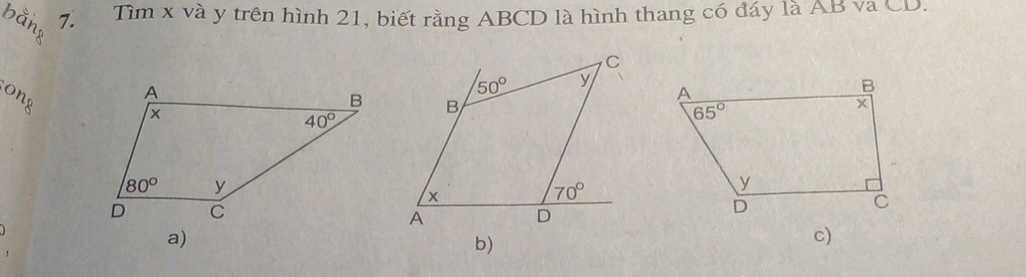

-- Number of words: 40


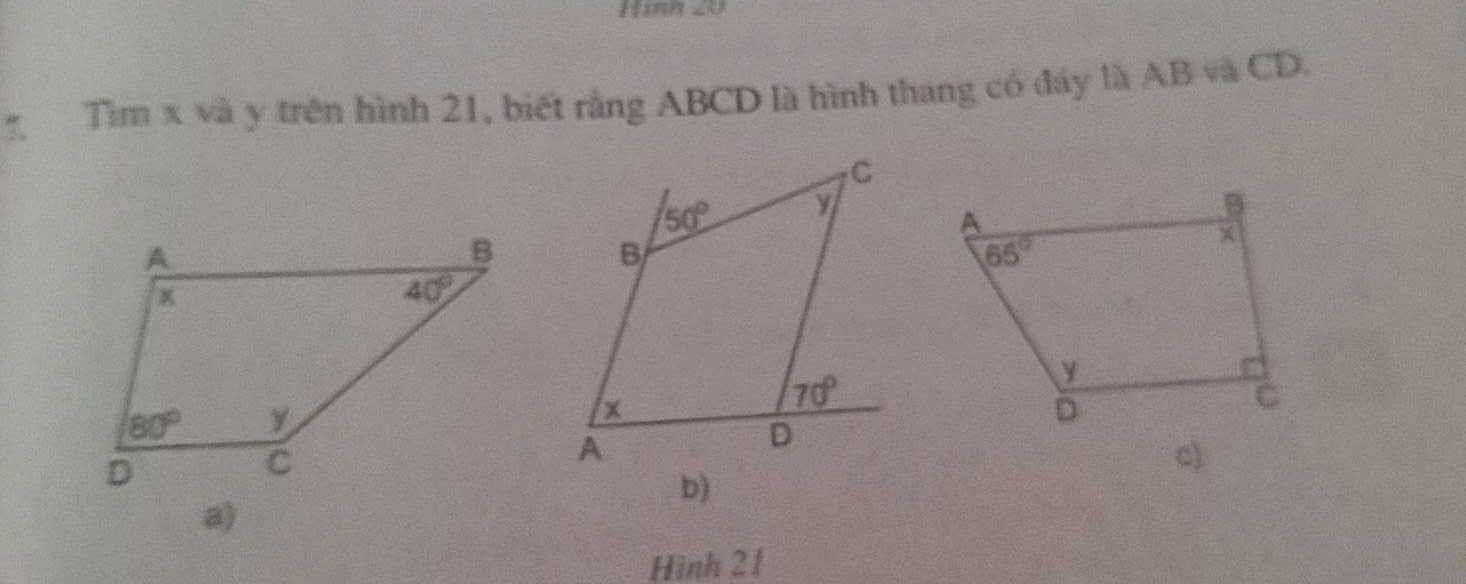

-- Number of words: 79


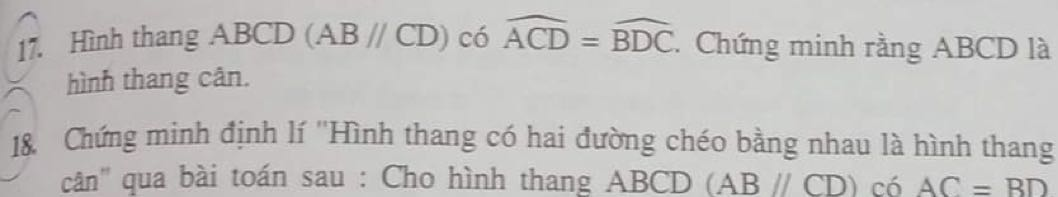

************
PAIRS: 26 - Cosine score: 0.3753294117845932
-- Number of words: 24


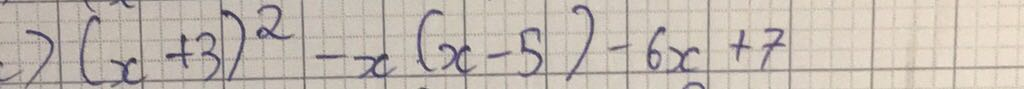

-- Number of words: 25


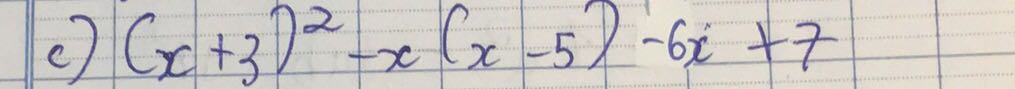

-- Number of words: 58


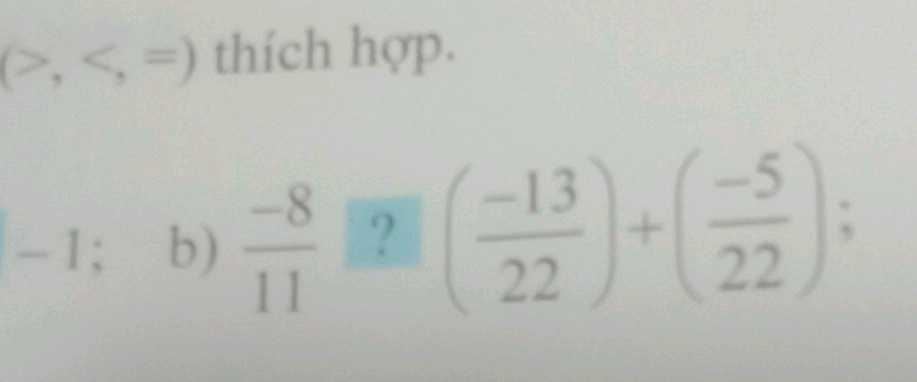

************
PAIRS: 27 - Cosine score: 0.37025422167338895
-- Number of words: 47


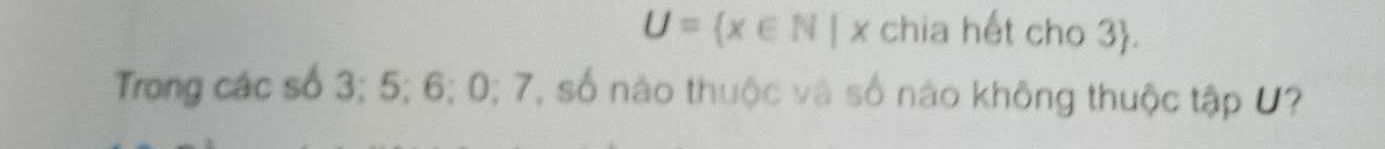

-- Number of words: 53


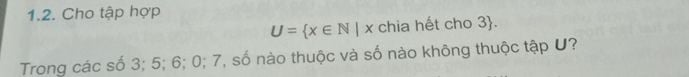

-- Number of words: 39


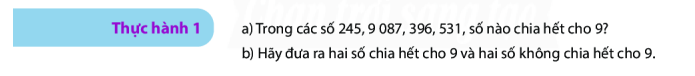

************
PAIRS: 28 - Cosine score: 0.30611907459886756
-- Number of words: 13


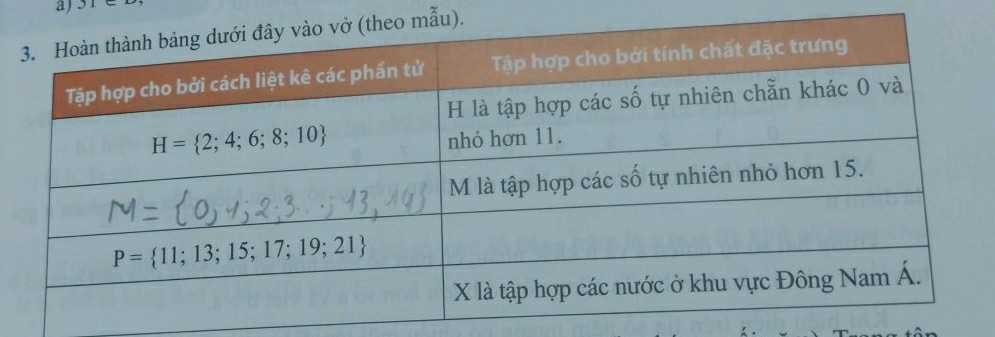

-- Number of words: 37


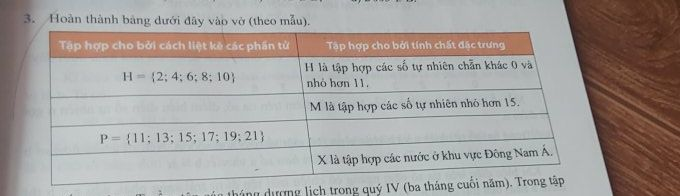

-- Number of words: 115


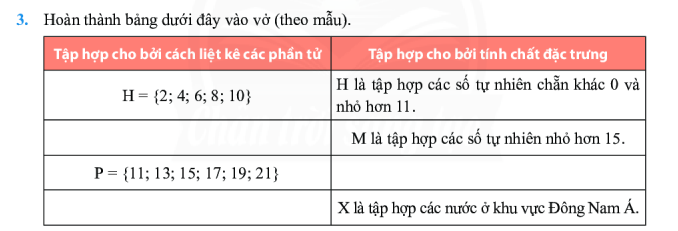

************
PAIRS: 29 - Cosine score: 0.29656407113573446
-- Number of words: 18


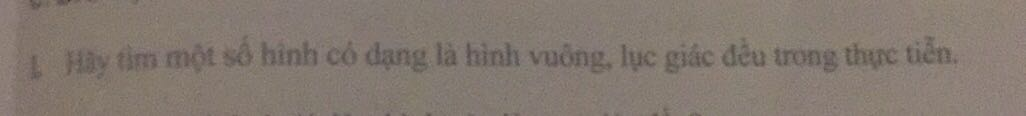

-- Number of words: 14


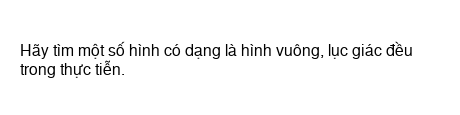

-- Number of words: 32


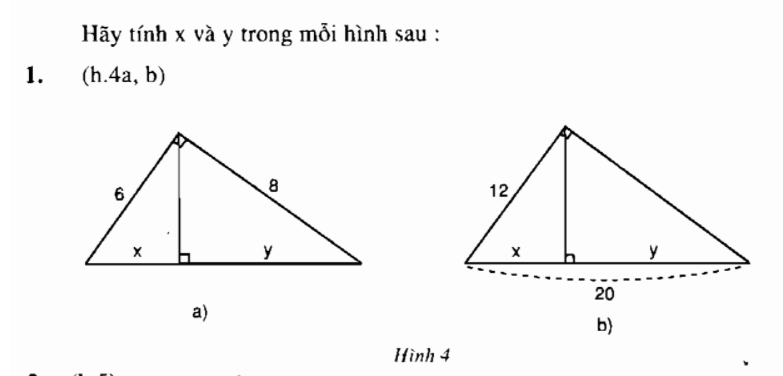

************
PAIRS: 30 - Cosine score: 0.2641582559414771
-- Number of words: 63


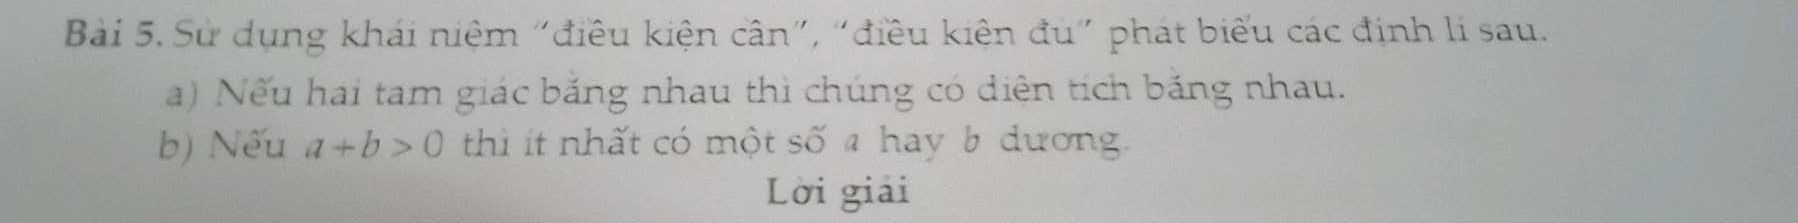

-- Number of words: 58


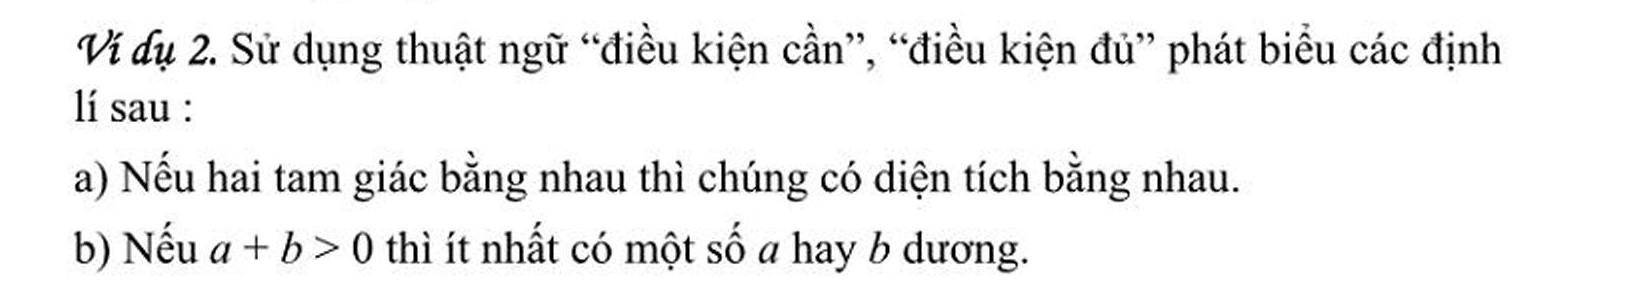

-- Number of words: 52


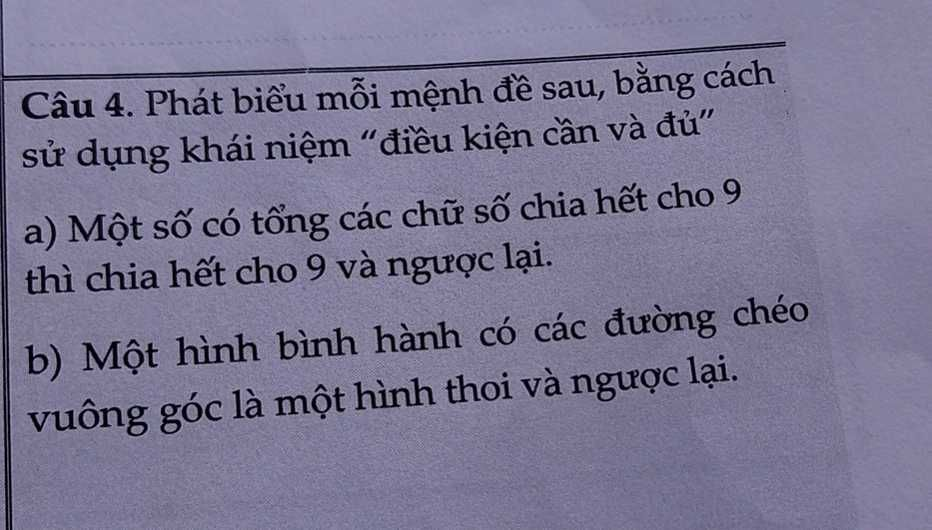

************
PAIRS: 31 - Cosine score: 0.23986522475756492
-- Number of words: 19


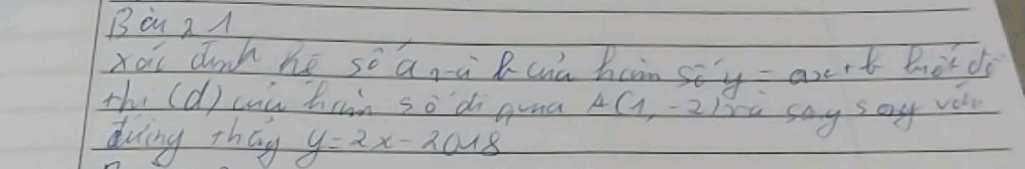

-- Number of words: 63


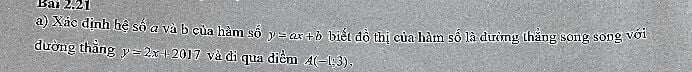

-- Number of words: 51


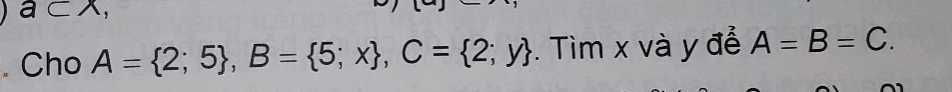

************
PAIRS: 32 - Cosine score: 0.218189122341854
-- Number of words: 68


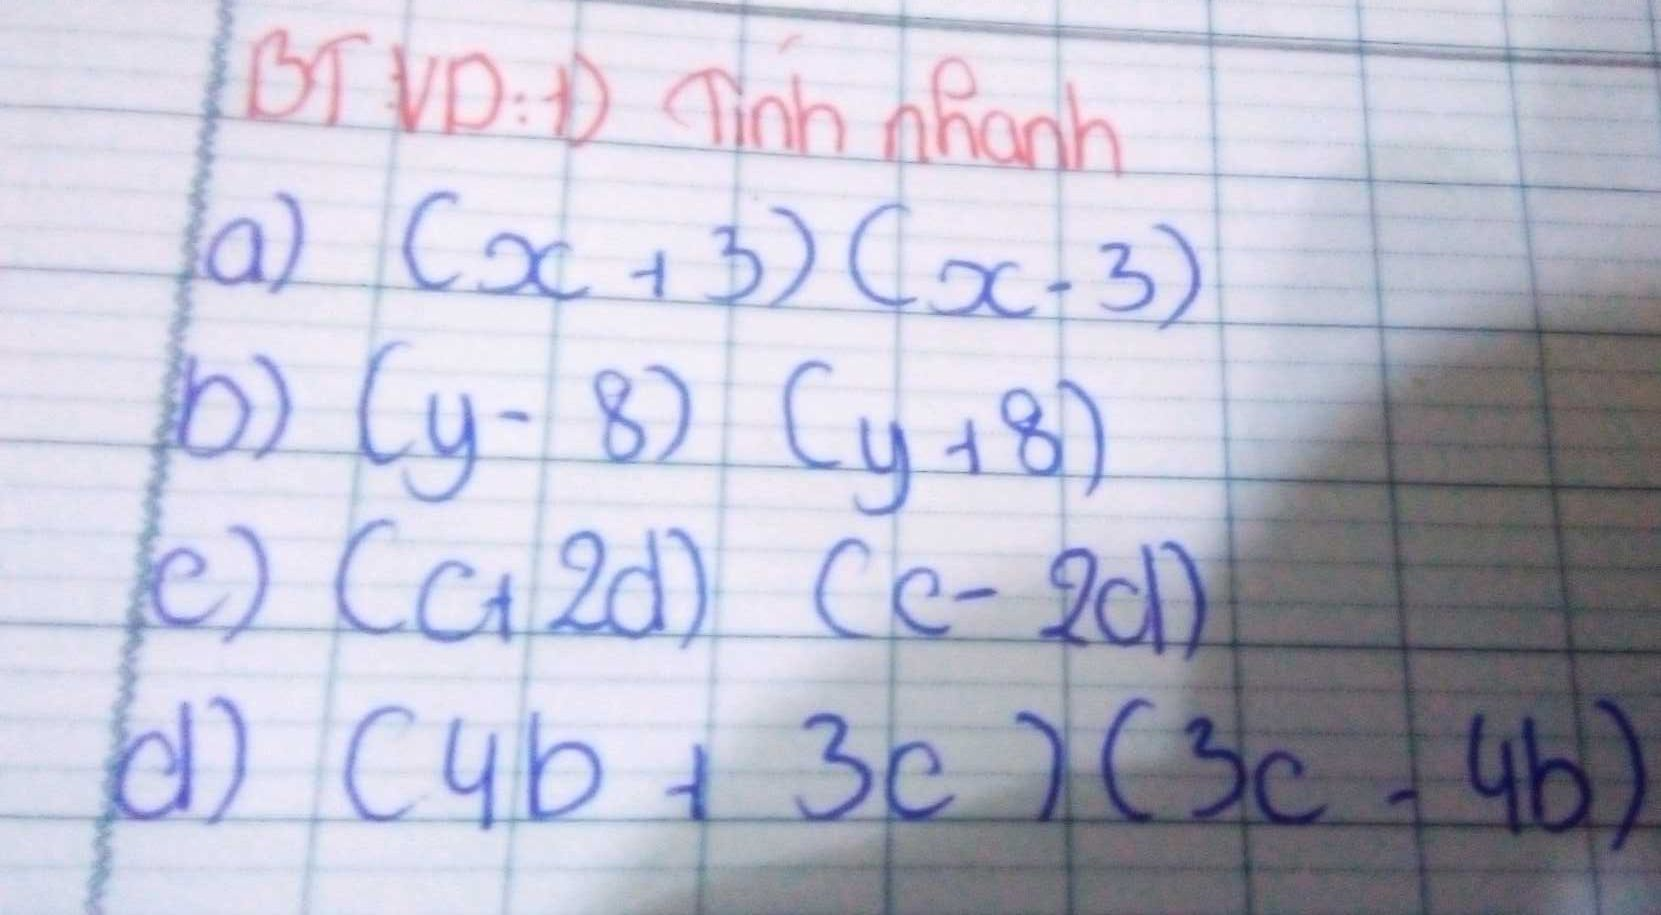

-- Number of words: 62


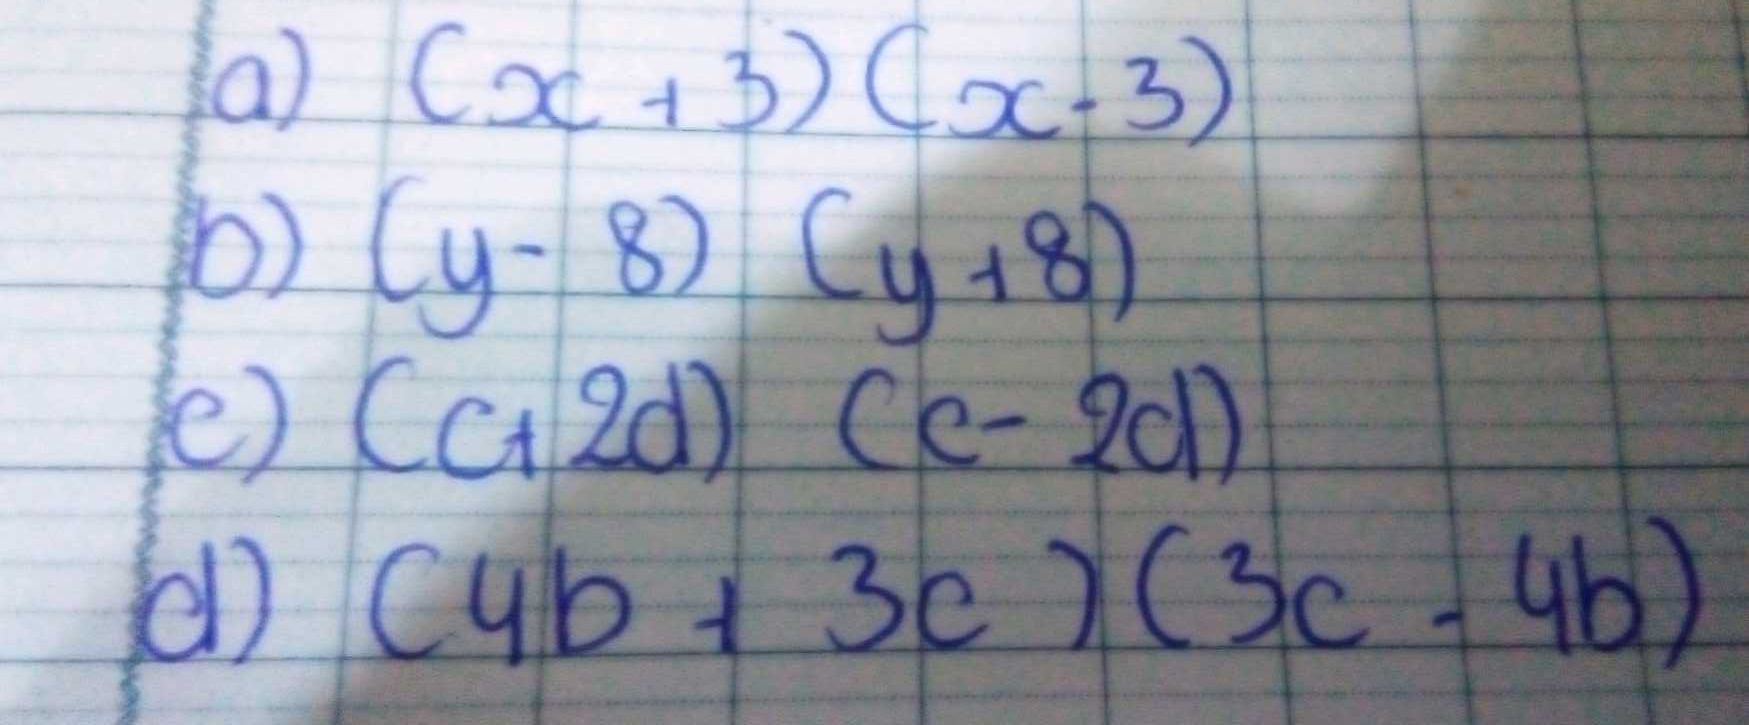

-- Number of words: 99


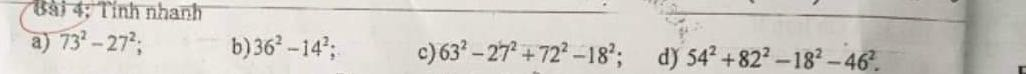

************
PAIRS: 33 - Cosine score: 0.20094742270597712
-- Number of words: 62


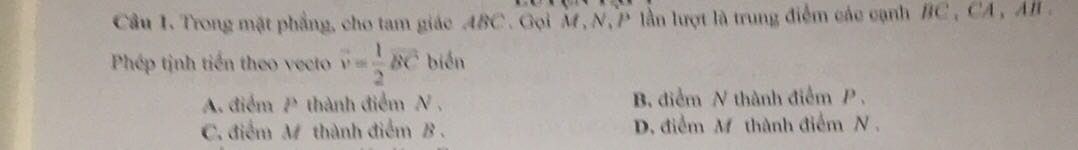

-- Number of words: 122


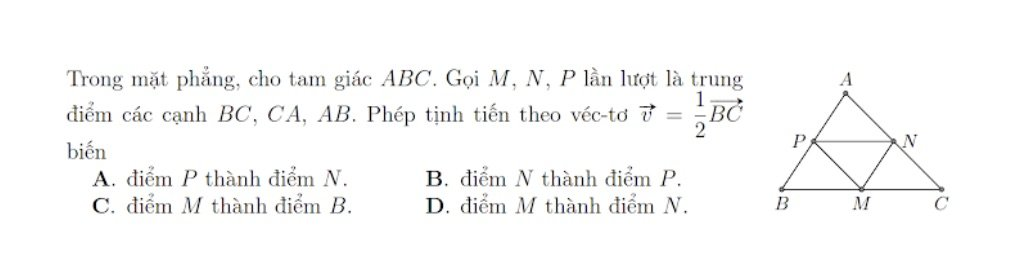

-- Number of words: 82


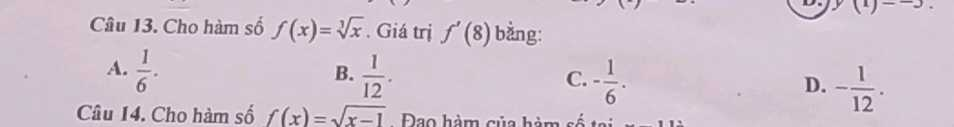

************
PAIRS: 34 - Cosine score: 0.19924139340296343
-- Number of words: 49


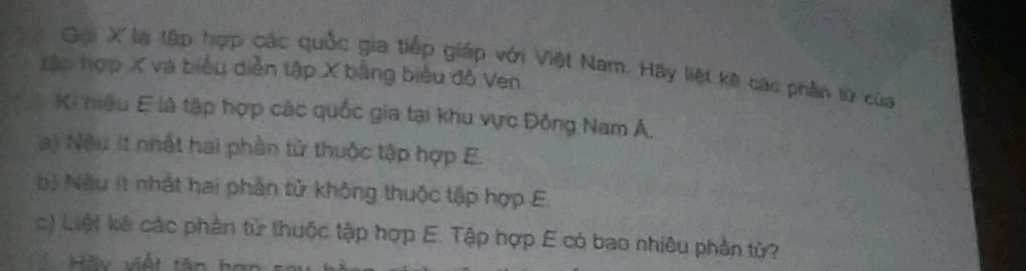

-- Number of words: 100


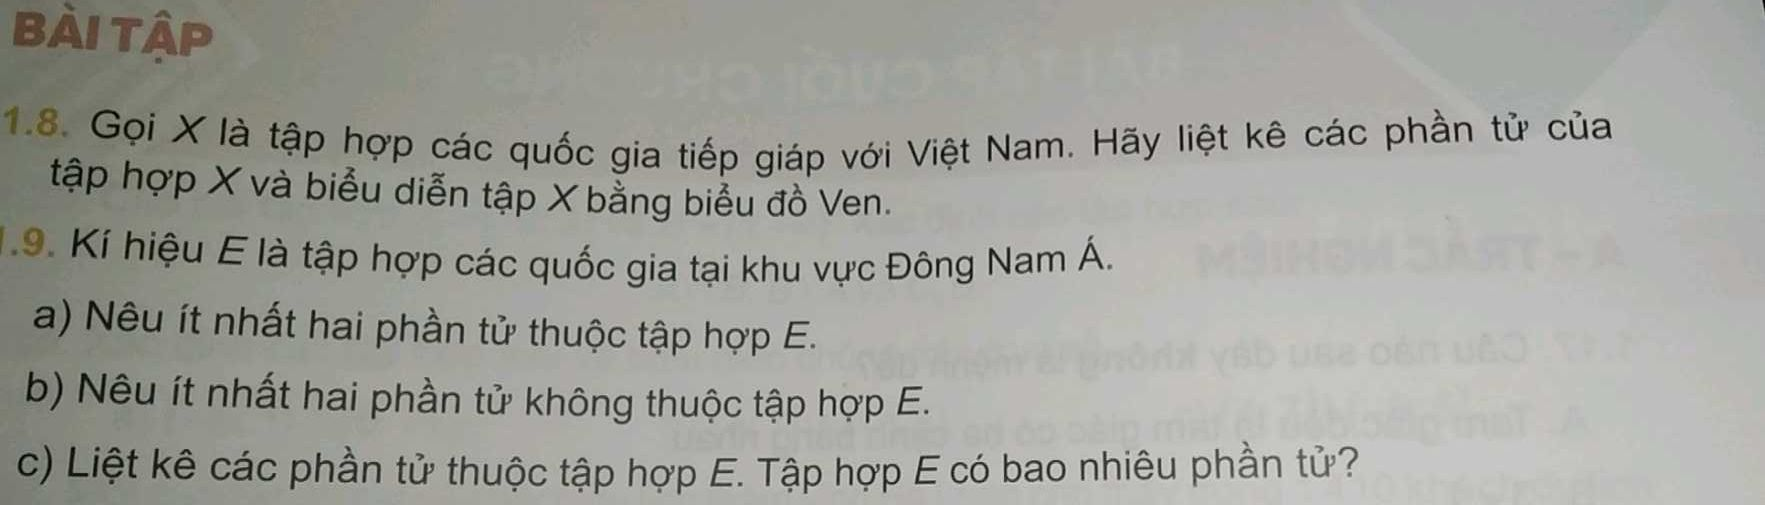

-- Number of words: 109


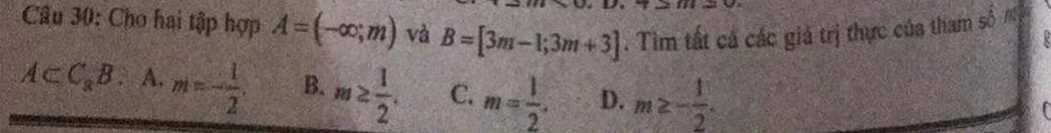

************
PAIRS: 35 - Cosine score: 0.1831189406006582
-- Number of words: 24


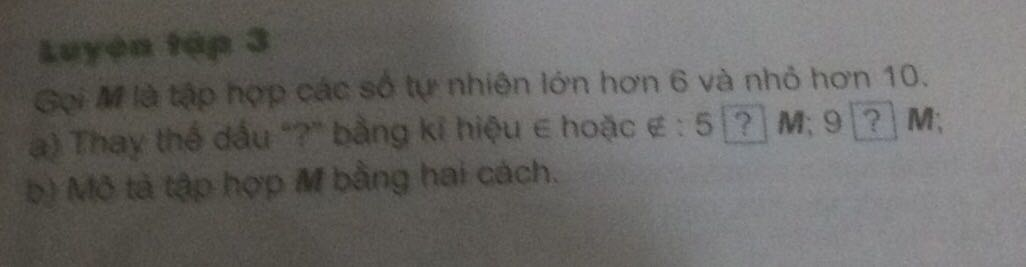

-- Number of words: 68


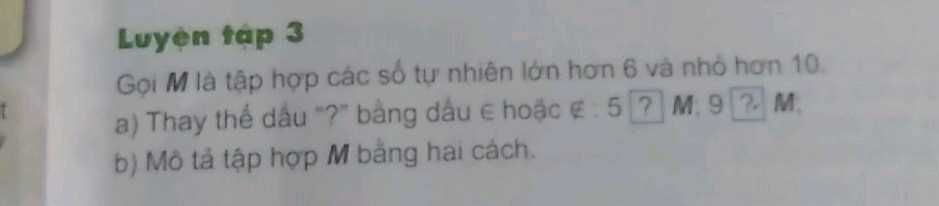

-- Number of words: 13


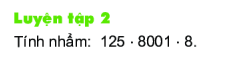

************
PAIRS: 36 - Cosine score: 0.1572464168340534
-- Number of words: 22


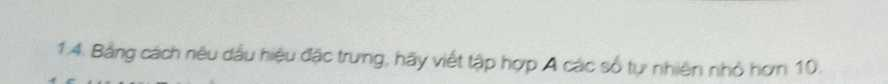

-- Number of words: 23


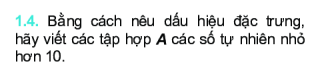

-- Number of words: 133


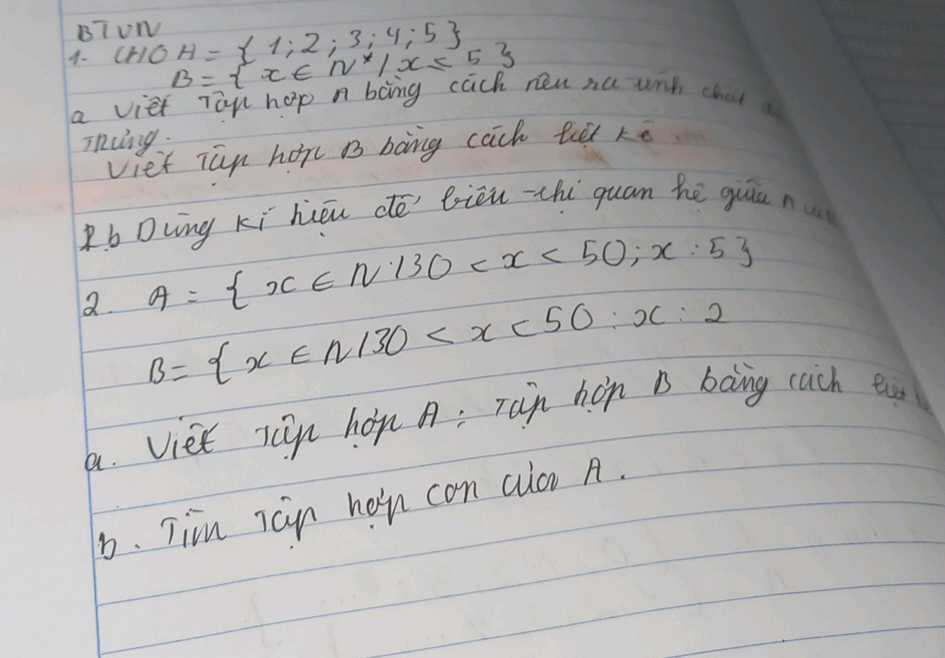

************
PAIRS: 37 - Cosine score: 0.0
-- Number of words: 10


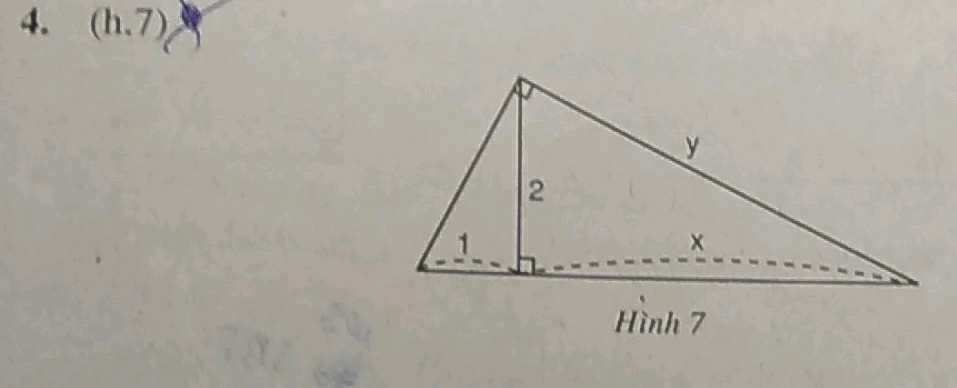

-- Number of words: 10


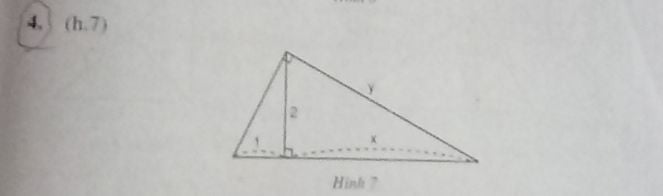

-- Number of words: 153


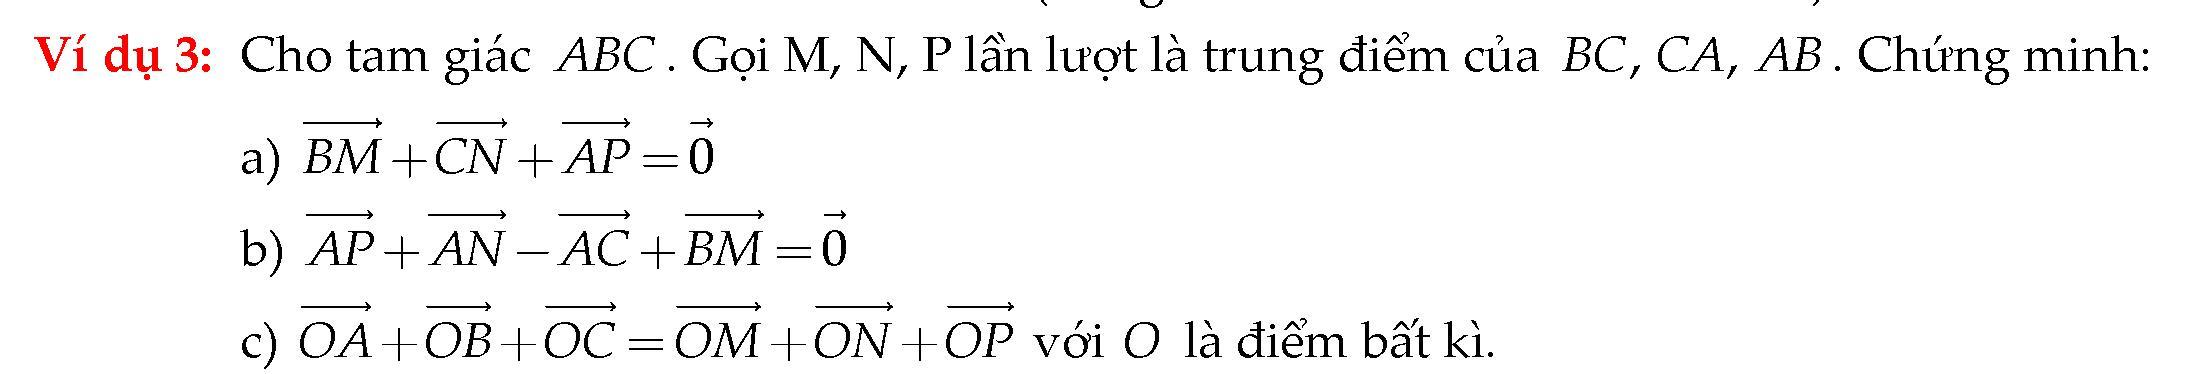

************
PAIRS: 38 - Cosine score: 0.0
-- Number of words: 34


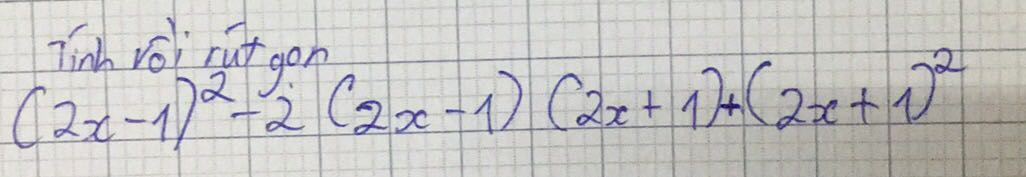

-- Number of words: 34


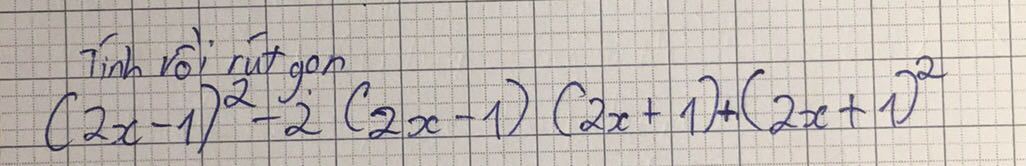

-- Number of words: 153


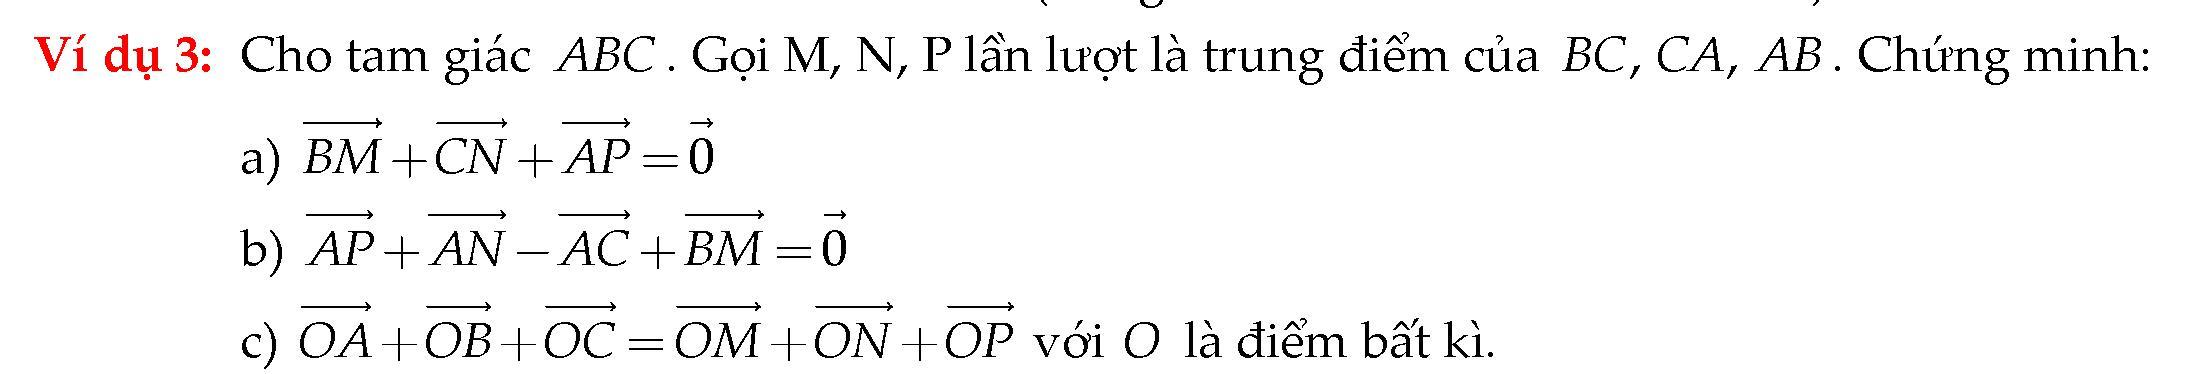

************
PAIRS: 39 - Cosine score: 0.0
-- Number of words: 20


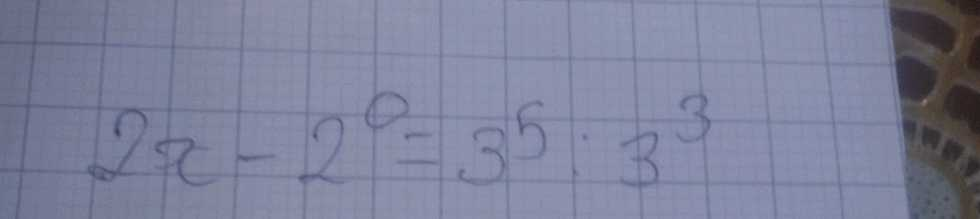

-- Number of words: 22


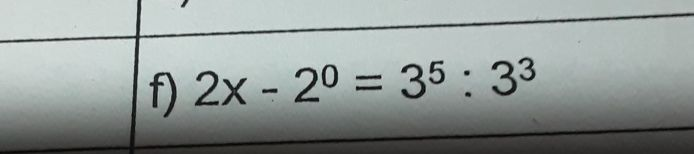

-- Number of words: 153


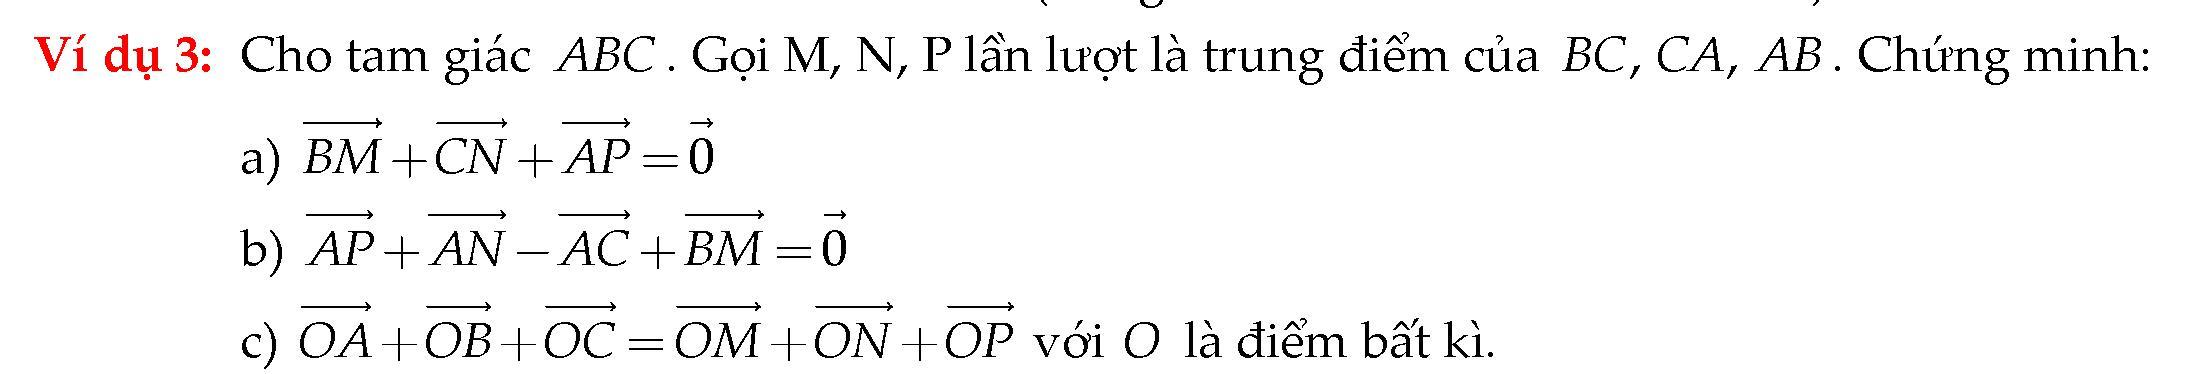

************
PAIRS: 40 - Cosine score: 0.0
-- Number of words: 34


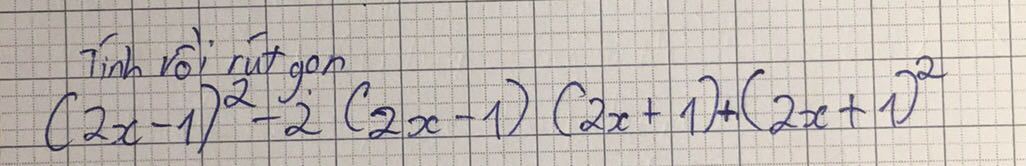

-- Number of words: 39


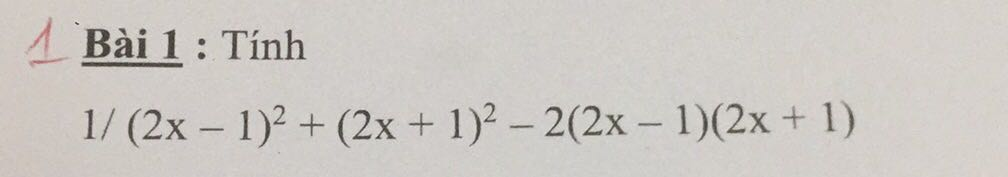

-- Number of words: 153


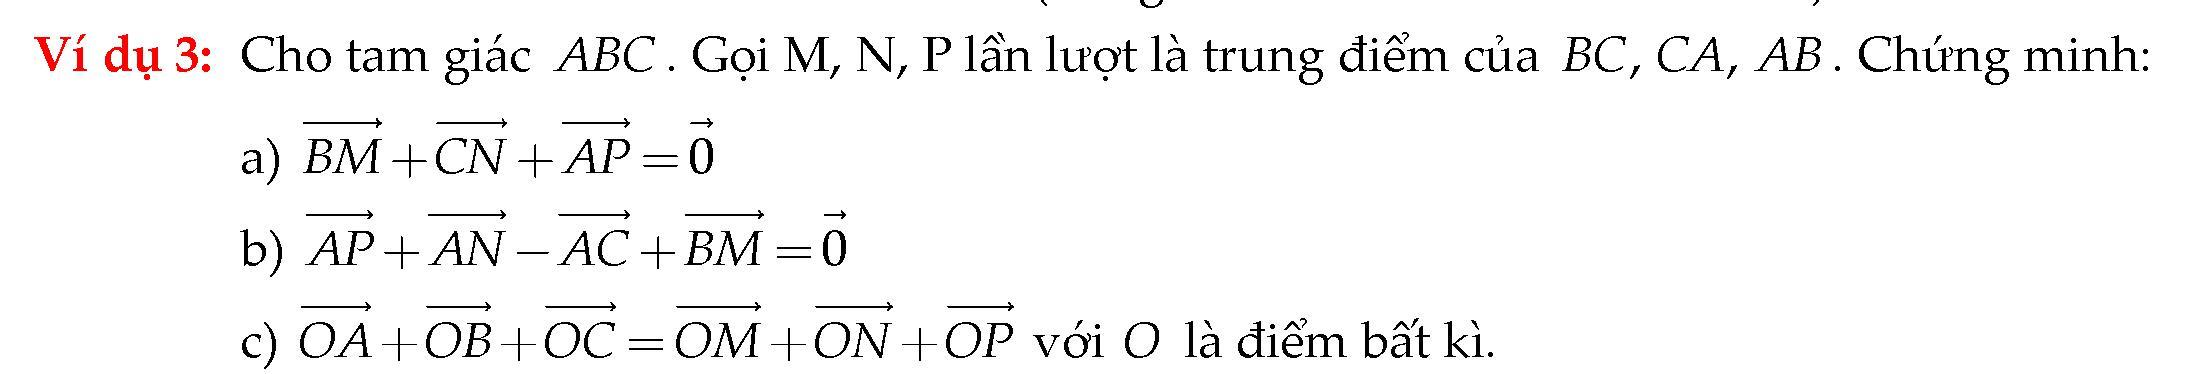

************
PAIRS: 41 - Cosine score: 0.0
-- Number of words: 19


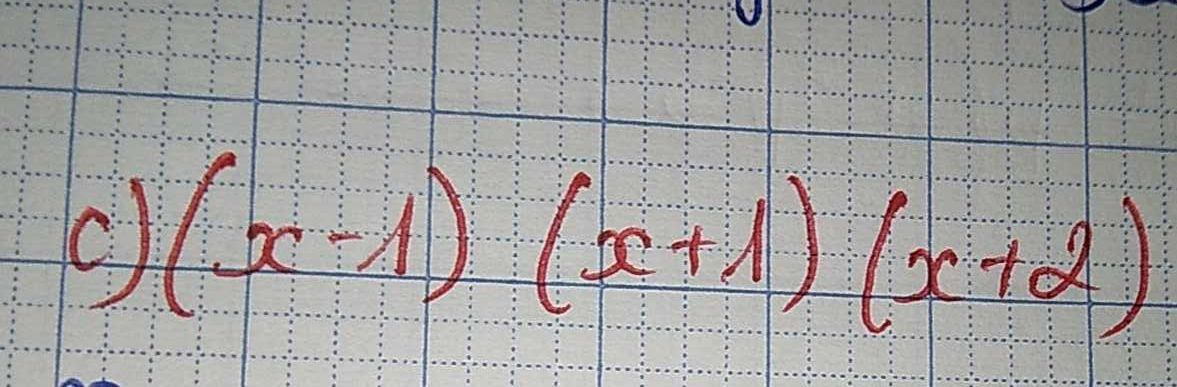

-- Number of words: 19


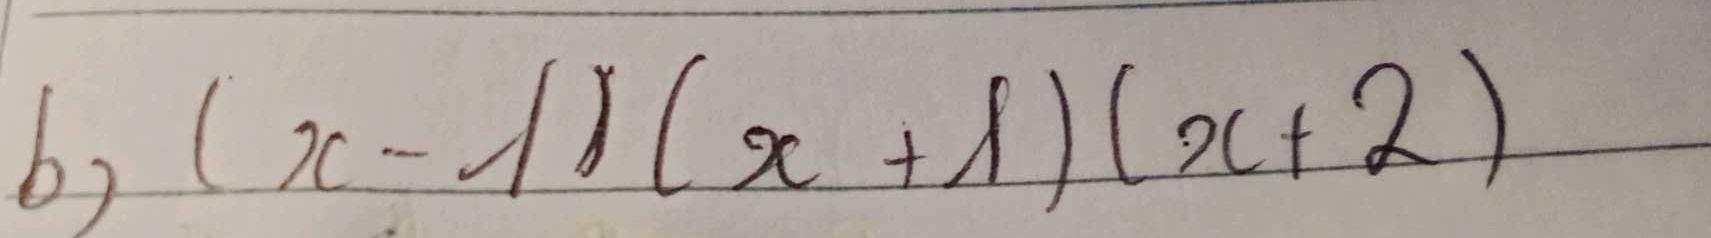

-- Number of words: 153


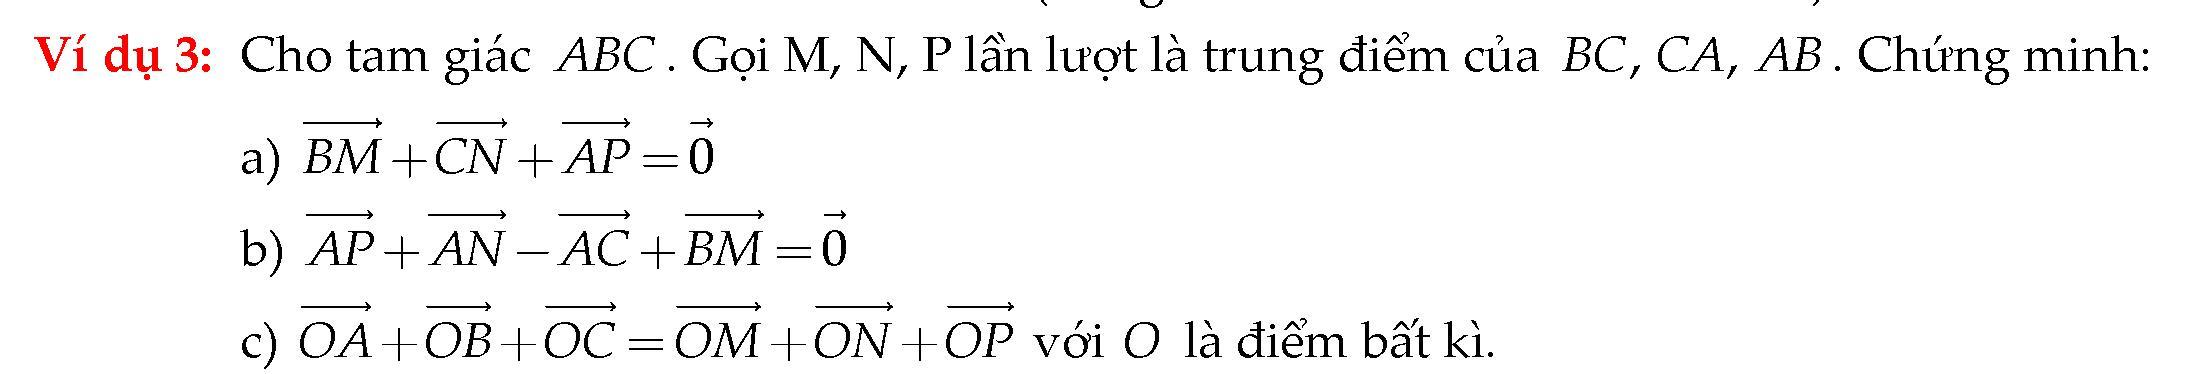

************
PAIRS: 42 - Cosine score: 0.0
-- Number of words: 26


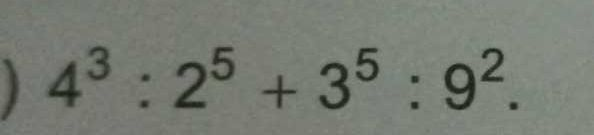

-- Number of words: 28


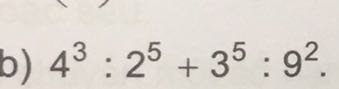

-- Number of words: 153


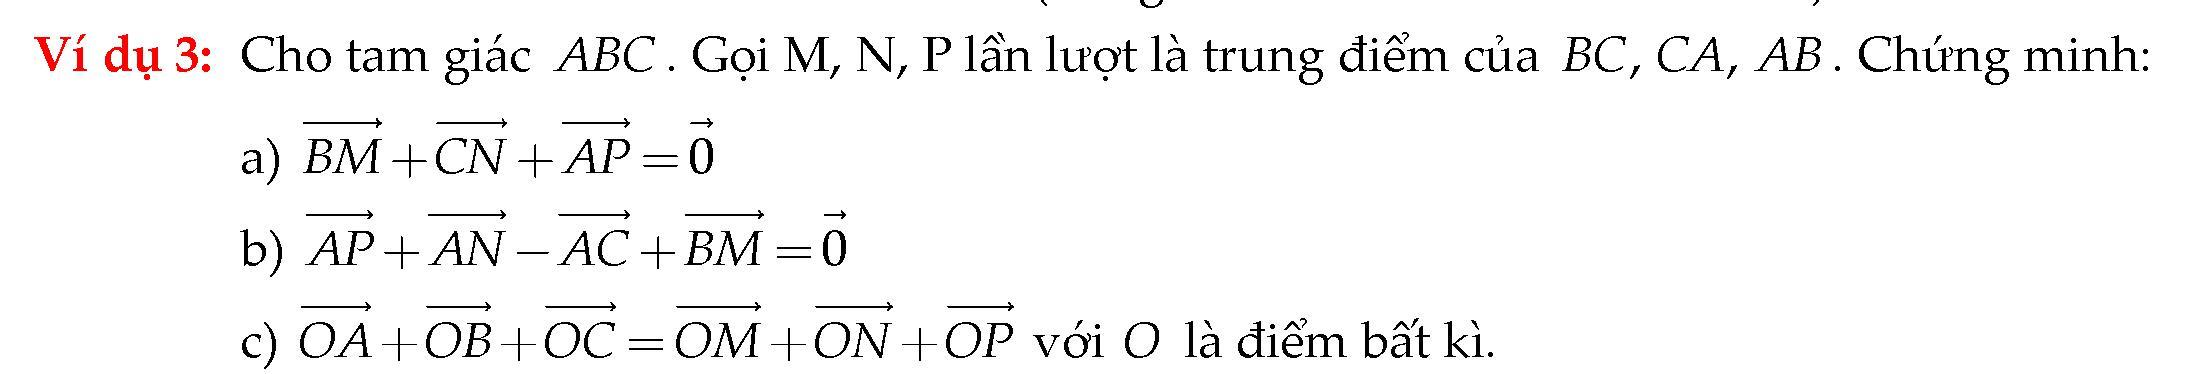

************


In [85]:
df_no_pos = df_no_pos.sort_values(by = 'score', ascending = False)

idx = 0
for url1, url2 in zip(df_no_pos['Question Image'].values, df_no_pos['cosine_image'].values):
    print('PAIRS: {} - Cosine score: {}'.format(idx + 1, df_no_pos['score'].values[idx]))
    print('-- Number of words:', df_no_pos['word_count_lookup'].values[idx])
    img0 = Disp.Image(requests.get(df_no_pos['Lookup Image'].values[idx]).content)
    display(img0)
    print('-- Number of words:', df_no_pos['word_count_question'].values[idx])
    img1 = Disp.Image(requests.get(url1).content)
    display(img1)
    print('-- Number of words:', df_no_pos['cosine_word_count_question'].values[idx])
    img2 = Disp.Image(requests.get(url2).content)
    display(img2)
    print('************')
    idx += 1

In [58]:
# N=5
# menMeans = (20,35,30,35,27)
# womenMeans = (25,32,34,20,25)

# ind = np.arange(N)
# width =0.5

# p1 = plt.bar(ind,menMeans, width,label='Men')
# p2 = plt.bar(ind,womenMeans, width,bottom=menMeans,label='Women')



# plt.ylabel('Scores')
# plt.title('Scores by group and gender')
# plt.xticks(ind,('G1','G2','G3','G4','G5'))
# plt.yticks(np.arange(0,81,10))
# plt.legend()
# plt.figure(figsize=(10, 6))
# plt.show()

# import pandas
# import matplotlib.pylab as plt
# import seaborn as sns
# plt.rcParams["figure.figsize"] = [7.00, 3.50]
# plt.rcParams["figure.autolayout"] = True
# df = pandas.DataFrame(dict(
#    number=[2, 5, 1, 6, 3],
#    count=[56, 21, 34, 36, 12],
#    select=[29, 13, 17, 21, 8]
# ))
# bar_plot1 = sns.barplot(x='number', y='count', data=df, label="count", color="red")
# bar_plot2 = sns.barplot(x='number', y='select', data=df, label="select", color="green")
# plt.legend(ncol=2, loc="upper right", frameon=True)
# plt.show()